In [365]:
pip install tensorflow

In [366]:
pip install --upgrade pip

In [367]:
pip install fitter

In [368]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [369]:
pip install --upgrade --user seaborn matplotlib

In [370]:
pip install --user --upgrade matplotlib

Note: you may need to restart the kernel to use updated packages.


In [371]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [372]:
# Import Library yang dibutuhkan

# Basic + date
import pandas as pd
import numpy as np
import prophet
import os

# Data Visualisasi
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math

# Statistik
from scipy import stats
from scipy.stats import norm
from scipy.stats import zscore as zs
from scipy import linalg as scipy_linalg
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fitter import Fitter, get_common_distributions, get_distributions
import pylab
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.diagnostics import performance_metrics

import pickle


import tensorflow as tf
from keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD


In [373]:
# Membaca dataset
ds_predict = pd.read_csv('dataset/ds_predict0019.csv')
ds_predict.head()

Date  gold_price  snp500_price  usdollarindex_price  crudeoil_price
0  2000-01-04       283.7        1399.4               100.41           25.55
1  2000-01-05       282.1        1402.1               100.38           24.91
2  2000-01-06       282.4        1403.5               100.65           24.78
3  2000-01-07       282.9        1441.5               100.80           24.22
4  2000-01-10       282.7        1457.6               100.99           24.67

In [374]:
ds_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5193 entries, 0 to 5192
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 5193 non-null   object 
 1   gold_price           5193 non-null   float64
 2   snp500_price         5193 non-null   float64
 3   usdollarindex_price  5193 non-null   float64
 4   crudeoil_price       5193 non-null   float64
dtypes: float64(4), object(1)
memory usage: 203.0+ KB


In [375]:
# Mengubah tipe data date
ds_predict['Date'] = pd.to_datetime(ds_predict['Date'])

In [376]:
# Setting Date sebagai index
ds_predict.set_index('Date', inplace=True)

In [377]:
ds_predict.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5193 entries, 2000-01-04 to 2019-12-31
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gold_price           5193 non-null   float64
 1   snp500_price         5193 non-null   float64
 2   usdollarindex_price  5193 non-null   float64
 3   crudeoil_price       5193 non-null   float64
dtypes: float64(4)
memory usage: 202.9 KB


In [378]:
# Memeriksa missing value
ds_predict.isnull().sum()

gold_price             0
snp500_price           0
usdollarindex_price    0
crudeoil_price         0
dtype: int64

# EDA (Exploratory Data Analysis)

## Data Adequacy

#### Data Adequaccy merujuk pada proses dan kriteria yang digunakan untuk menentukan apakah data yang tersedia cukup memadai untuk analisis yang diinginkan.
Aspek-aspek yang Dinilai dalam Data Adequacy
1. Kelengkapan Data (Completeness): Memastikan bahwa semua data yang diperlukan ada dan tidak ada nilai yang hilang yang signifikan.
2. Keakuratan Data (Accuracy): Memastikan bahwa data tersebut akurat dan sesuai dengan realita
3. Konsistensi Data (Consistency): Memastikan bahwa data konsisten di seluruh dataset, tanpa adanya anomali atau ketidaksesuaian
4. Relevansi Data (Relevance): Memastikan bahwa data yang dikumpulkan relevan dengan tujuan analisis atau pemodelan
5. Keandalan Data (Reliability): Memastikan bahwa data dapat dipercaya dan berasal dari sumber yang dapat diandalkan.

In [379]:
ds_predict_list = ['gold_price', 'snp500_price', 'usdollarindex_price', 'crudeoil_price']

In [380]:
# Cek Kelengkapan Data: Memastikan bahwa semua data yang diperlukan ada dan tidak ada nilai yang hilang yang signifikan.
ds_predict.isnull().sum()

gold_price             0
snp500_price           0
usdollarindex_price    0
crudeoil_price         0
dtype: int64

In [381]:
# Cek Keakuratan data : Memastikan bahwa data tersebut akurat dan sesuai dengan realita
# Contoh sederhana: memeriksa nilai negatif pada kolom yang tidak seharusnya negatif
ds_predict_list = ['gold_price', 'snp500_price', 'usdollarindex_price', 'crudeoil_price']
nilai_negatif = ds_predict[ds_predict_list] < 0
total_nn = nilai_negatif.sum().sum()


for index, row in ds_predict.iterrows():
    for col_index, value in enumerate(row[ds_predict_list]):
        if nilai_negatif.loc[index, ds_predict_list[col_index]]:
         print(f"Nilai negatif ditemukan di kolom '{ds_predict_list[col_index]}': {value}, pada tanggal '{index}'")

# Print a summary message
print("\nTotal nilai negatif ditemukan:", nilai_negatif.sum().sum())


Total nilai negatif ditemukan: 0


In [382]:
# Cek Konsitensi Data : Memastikan bahwa data konsisten di seluruh dataset, tanpa adanya anomali atau ketidaksesuaian
ds_predict.duplicated().sum()

0

In [383]:
# Cek Relevansi data Missing Value : Memastikan bahwa data yang dikumpulkan relevan dengan tujuan analisis atau pemodelan
ds_predict.isnull().sum()

gold_price             0
snp500_price           0
usdollarindex_price    0
crudeoil_price         0
dtype: int64

In [384]:
# Meringkasstatistik deskriptif untuk kolom-kolom yang dipilih.
# Mencakup beberapa statistik umum seperti jumlah data non-null, mean, standar deviasi, nilai minimum, kuartil, dan nilai maksimum.
ds_predict[ds_predict_list].describe()

gold_price  snp500_price  usdollarindex_price  crudeoil_price
count  5193.000000   5193.000000          5193.000000     5193.000000
mean    944.649355   1583.568808            90.655783       62.067058
std     462.050566    588.167781            11.614999       26.093831
min     256.600000    676.500000            71.330000       17.450000
25%     428.400000   1158.300000            80.980000       41.580000
50%    1094.000000   1367.700000            88.790000       58.910000
75%    1297.100000   1995.800000            97.320000       82.820000
max    1891.900000   3794.788000           120.900000      145.290000

In [385]:
# Melakukan analisis korelasi pada setiap kolom
ds_predict[ds_predict_list].corr()

gold_price  snp500_price  usdollarindex_price  \
gold_price             1.000000      0.519954            -0.507351   
snp500_price           0.519954      1.000000             0.141890   
usdollarindex_price   -0.507351      0.141890             1.000000   
crudeoil_price         0.648822      0.061078            -0.821113   

                     crudeoil_price  
gold_price                 0.648822  
snp500_price               0.061078  
usdollarindex_price       -0.821113  
crudeoil_price             1.000000

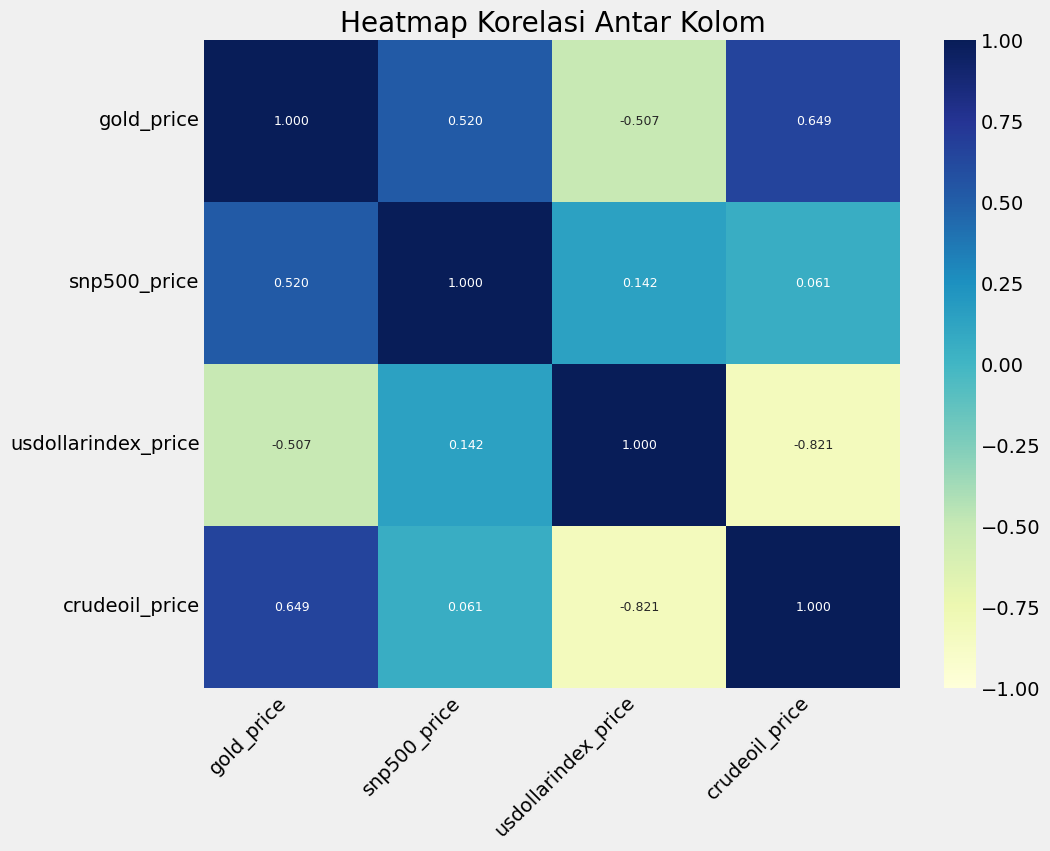

In [386]:
# Visualisasi Data Seaborn
# Membuat figure heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Generate heatmap
sns.heatmap(ds_predict[ds_predict_list].corr(), cmap='YlGnBu', annot=True, fmt='.3f', annot_kws={"fontsize": 9}, vmin='-1')

# Menambahkan Judul
ax.set_title('Heatmap Korelasi Antar Kolom')

# Rotasi axis-y agar mudah dibaca
plt.xticks(rotation=45, ha='right')

# Show the heatmap
plt.show()

Korelasi Harga minyak mentah dengan harga variabel lainnya:


1.   Korelasi antara harga minyak mentah dengan harga emas memiliki nilai sebesar 0.550. Korelasi sebesar 0.555 antara harga minyak mentah dan emas menunjukkan bahwa terdapat hubungan positif antara kedua variabel tersebut. Nilai korelasi ini menandakan bahwa ketika harga minyak mentah naik, cenderung juga terjadi kenaikan pada harga emas, dan sebaliknya
2.   Korelasi antara harga minyak mentah dan S&P 500 sebesar 0.173 menunjukkan bahwa hubungan antara harga minyak mentah dan harga S&P 500 cukup lemah secara positif. Ini mengindikasikan bahwa ada kecenderungan bahwa ketika harga minyak mentah naik, harga S&P 500 juga cenderung naik, meskipun hubungannya tidak kuat.
3. Korelasi antara harga minyak mentah dan harga indeks dolar sebesar -0.649 menunjukkan hubungan yang cukup kuat secara negatif. Ini mengindikasikan bahwa ada kecenderungan bahwa ketika harga minyak mentah naik, harga indeks dolar cenderung turun, dan sebaliknya. Nilai korelasi yang mendekati -1 menunjukkan bahwa hubungan antara kedua variabel ini adalah negatif dan relatif kuat.





In [387]:
# data input
data_input = ds_predict.drop(columns="crudeoil_price")

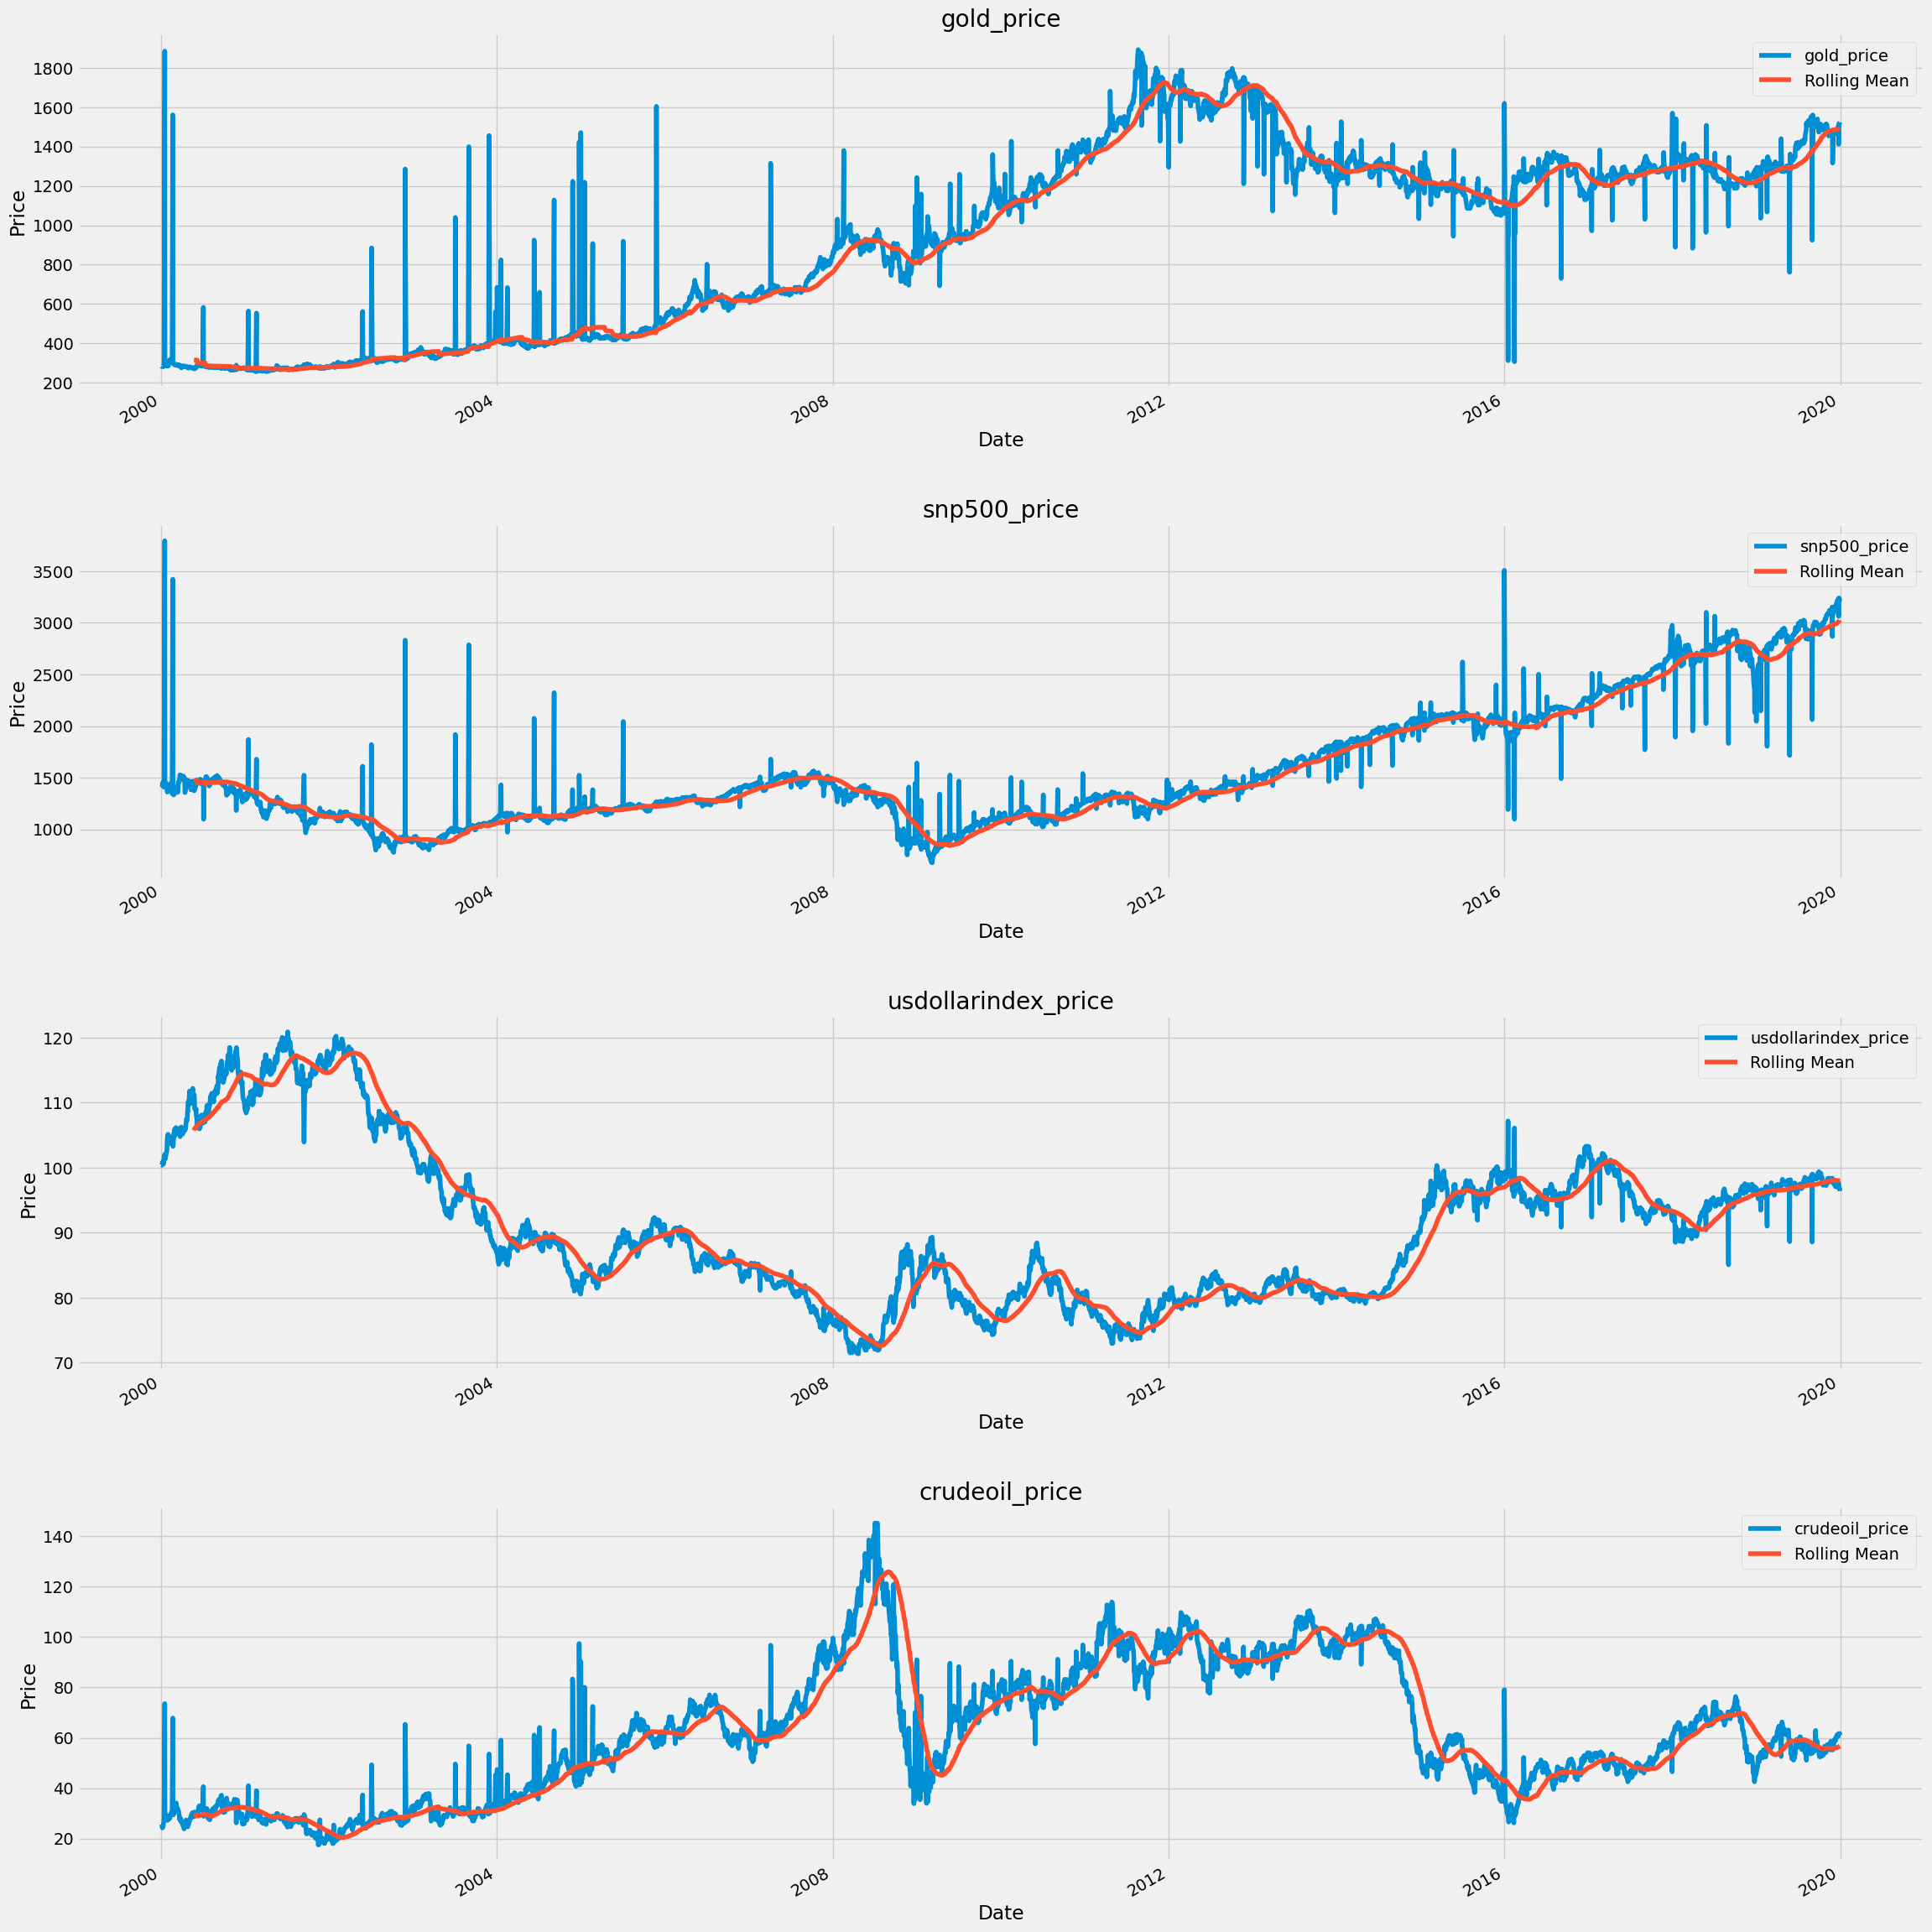

In [388]:
# Rolling Mean
# Rolling mean adalah sebuah metode statistik yang digunakan untuk menghaluskan data dengan mengambil rata-rata dari sejumlah titik data -
# yang berdekatan dalam rentang waktu yang bersifat bergulir atau bergerak.
data = ds_predict
ds_predict_list = data.columns

fig = plt.figure(figsize = (24,24))
plt.style.use('fivethirtyeight')
for i in range(4):
    ax = fig.add_subplot(4,1,i+1)
    ax.plot(data.iloc[:,i], label=ds_predict_list[i])
    data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
    ax.set_title(ds_predict_list[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

Grafik rolling mean (rata-rata bergerak) digunakan untuk menghaluskan tren atau pola dalam data dengan cara mengambil rata-rata dari sejumlah titik data berurutan. Berikut ini merupakan Rolling Mean dari masing-masing variabel:

1.   Pada periode tahun 2000 - 2023 harga emas dan harga minyak mentah memiliki trend harga yang cenderung fluktuatif.
2.   Pada periode yang sama, trend harga S&P 500 dan Index Dollar cenderung meningkat.




C:\Users\Rizal\AppData\Local\Temp\ipykernel_19660\316726312.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.iloc[:,i], label=ds_predict_list[i], color='dodgerblue').set_title("Distribusi Plot dari {}".format(ds_predict_list[i]),axes=ax)
C:\Users\Rizal\AppData\Local\Temp\ipykernel_19660\316726312.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github

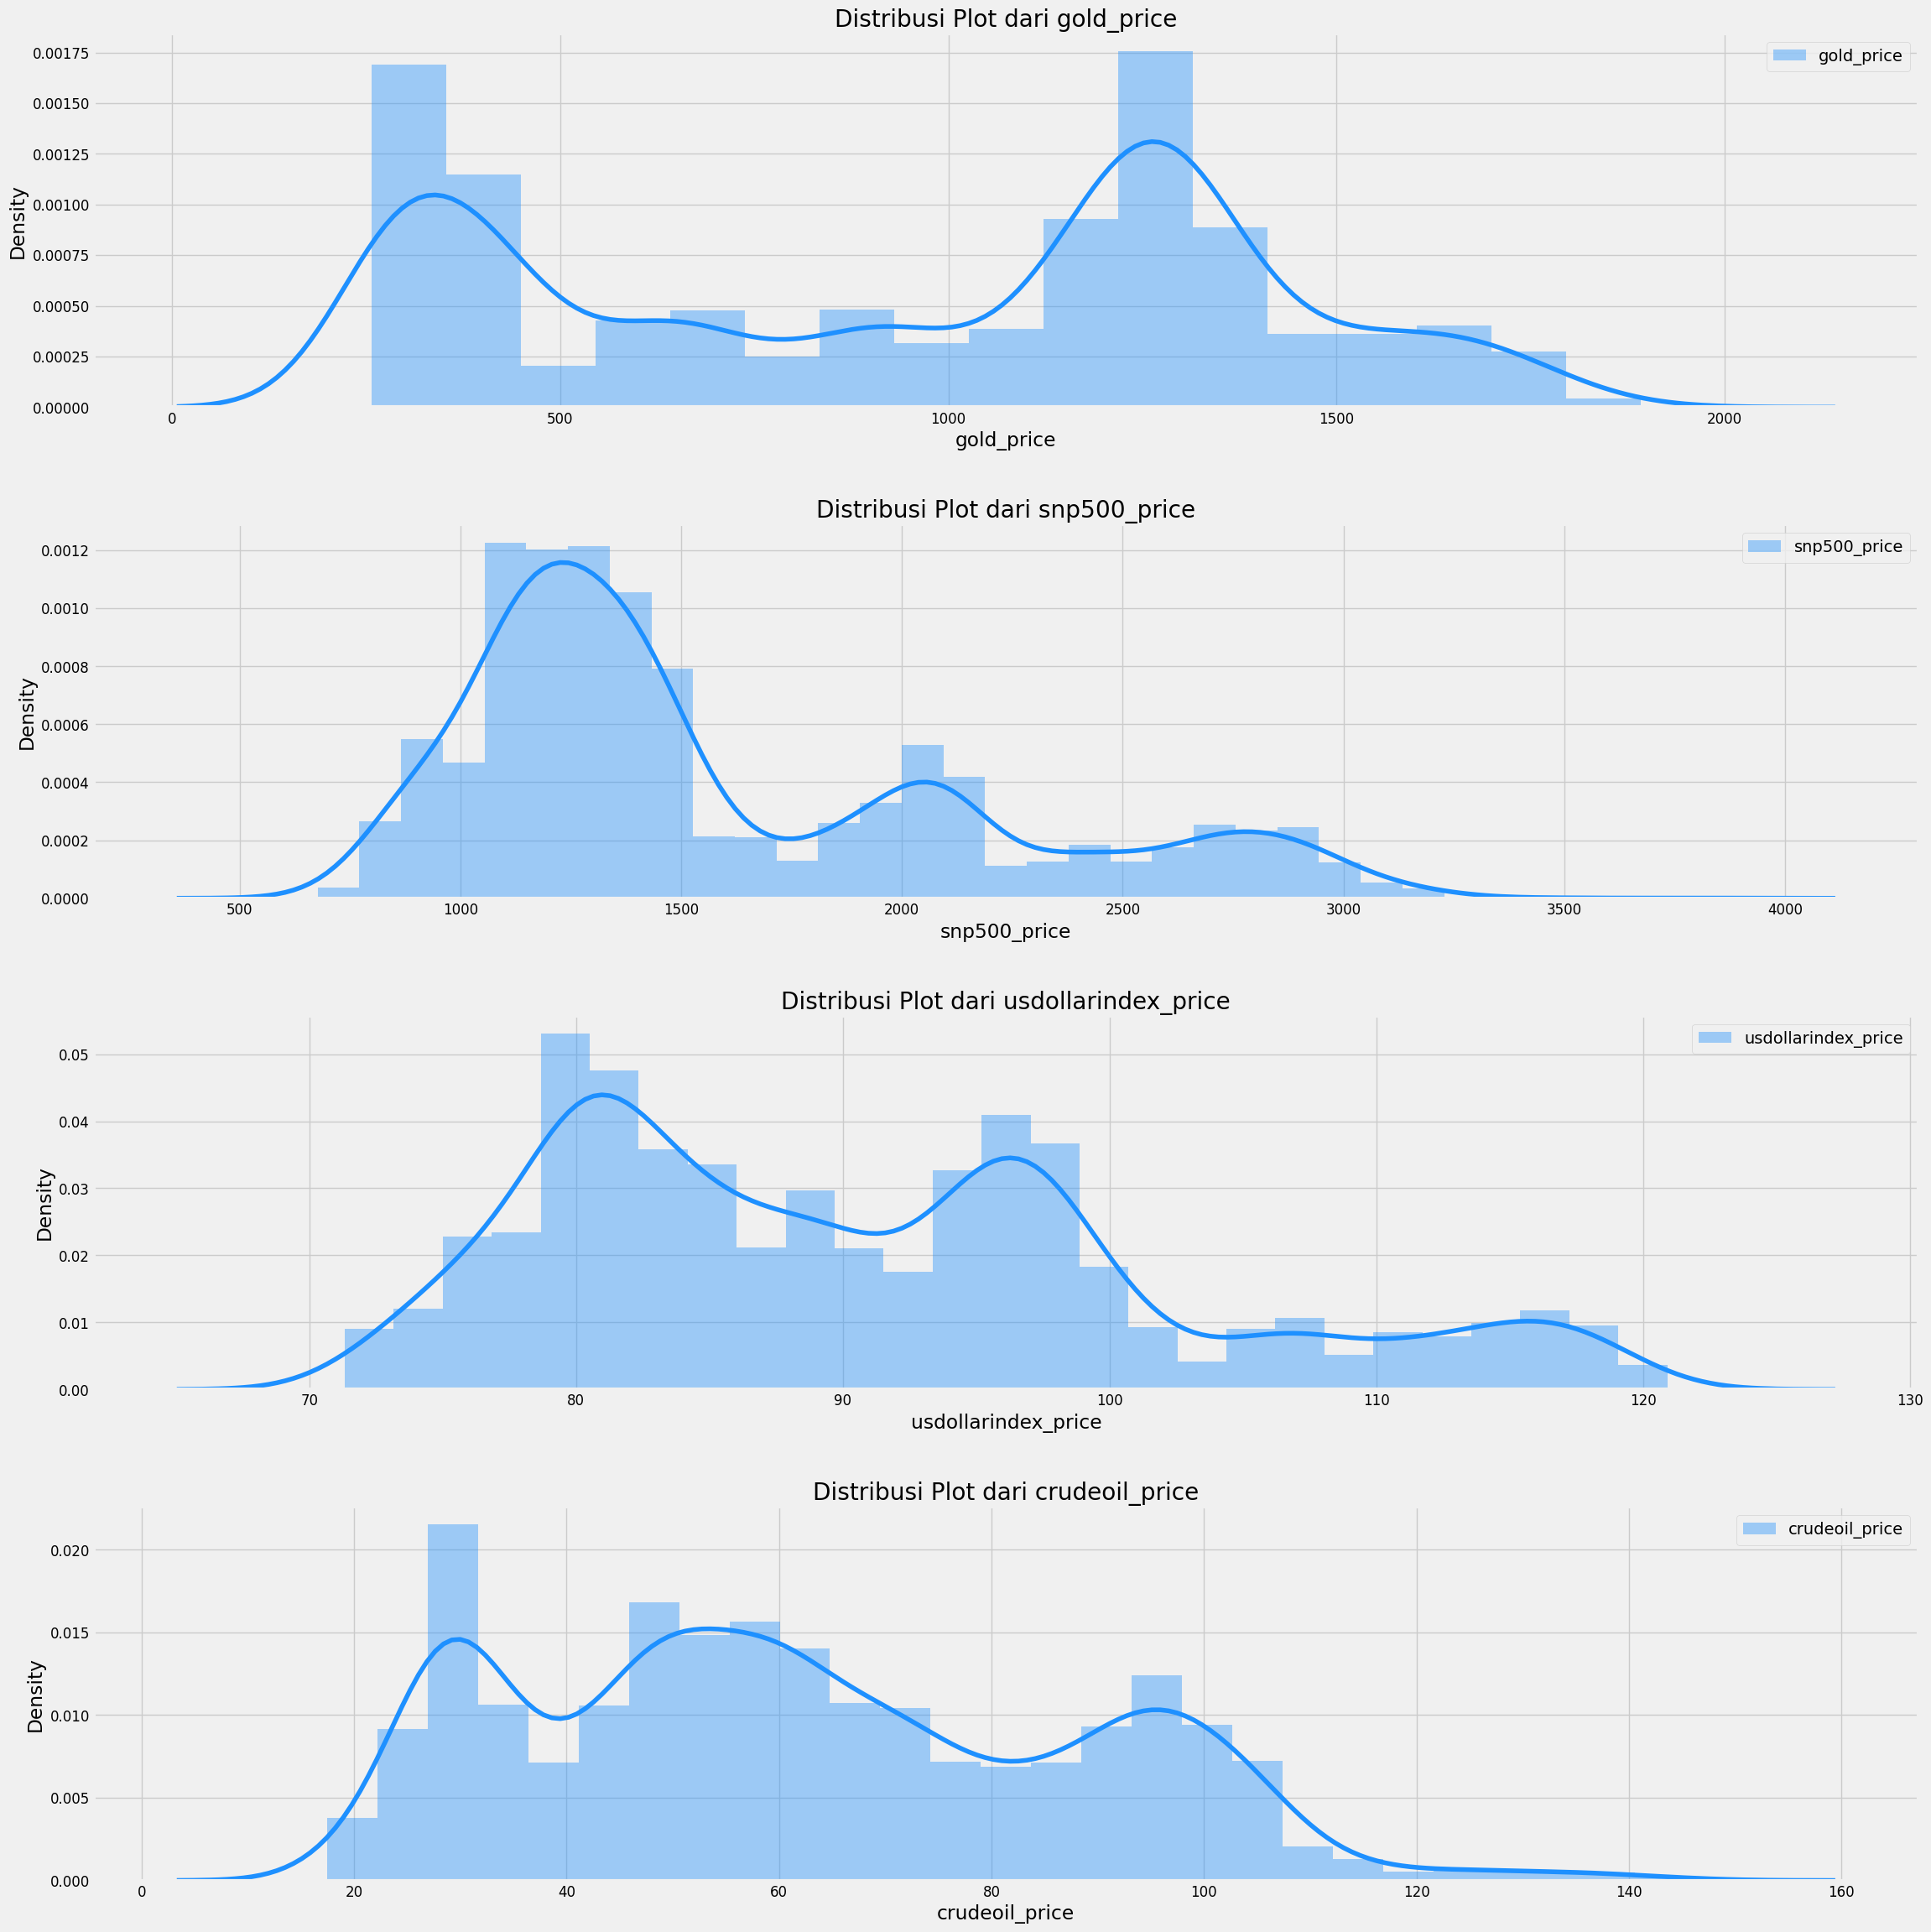

In [389]:
data = ds_predict
ds_predict_list = data.columns

fig = plt.figure(figsize = (24,24))
plt.style.use('fivethirtyeight')
for i in range(4):
    ax = fig.add_subplot(4,1,i+1)
    sns.distplot(data.iloc[:,i], label=ds_predict_list[i], color='dodgerblue').set_title("Distribusi Plot dari {}".format(ds_predict_list[i]),axes=ax)
    ax.tick_params(labelsize=12)
    plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

Berdasarkan plot distribusi tiap variabel, semua variabel yang ada memiliki penyebaran data tidak normal. Dilihat dari bentuk plot, dimana plo yang normal akan terlihat seperti lonceng.

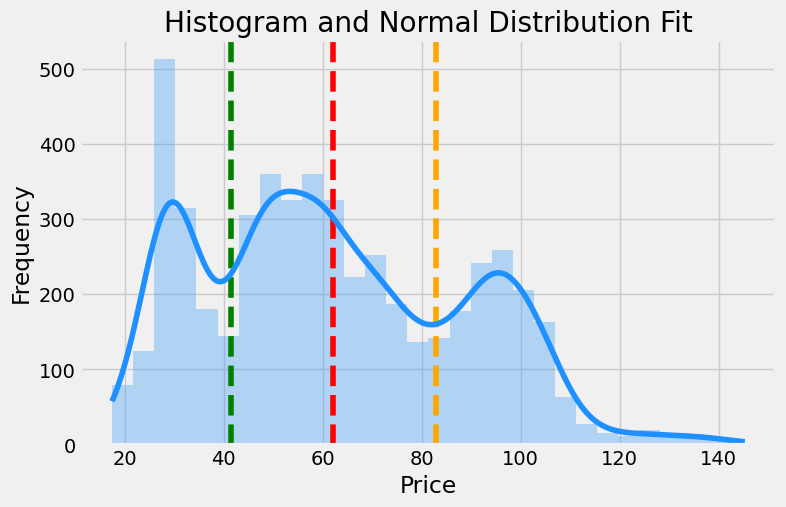

Kolmogorov-Smirnov test : stat=393.371, p=0.000
Sample data tidak berasal dari distribusi normal (Menolak H0)


In [390]:
# Uji Normalitas

plt.figure(figsize=(8, 5))
plt.axvline(x=np.mean(ds_predict['crudeoil_price']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(ds_predict['crudeoil_price'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(ds_predict['crudeoil_price'],75),c='orange', ls='--',label = '75th percentile:Q3' )
sns.histplot(ds_predict['crudeoil_price'], bins=30, kde=True, color='dodgerblue', alpha=0.3, edgecolor='none')

plt.title('Histogram and Normal Distribution Fit')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Uji Kolmogorov Smirnov (ktest)
stat, p = stats.normaltest(ds_predict['crudeoil_price'])
print("Kolmogorov-Smirnov test : stat=%.3f, p=%.3f" % (stat, p))

# Menentukan hasil uji
alpha = 0.05
if p > alpha:
    print("Sample data berasal dari distribusi normal (Tidak bisa menolak H0)")
else:
    print("Sample data tidak berasal dari distribusi normal (Menolak H0)")


c:\Users\Rizal\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Text(0.5, 1.0, 'Box Plot Year WTI')

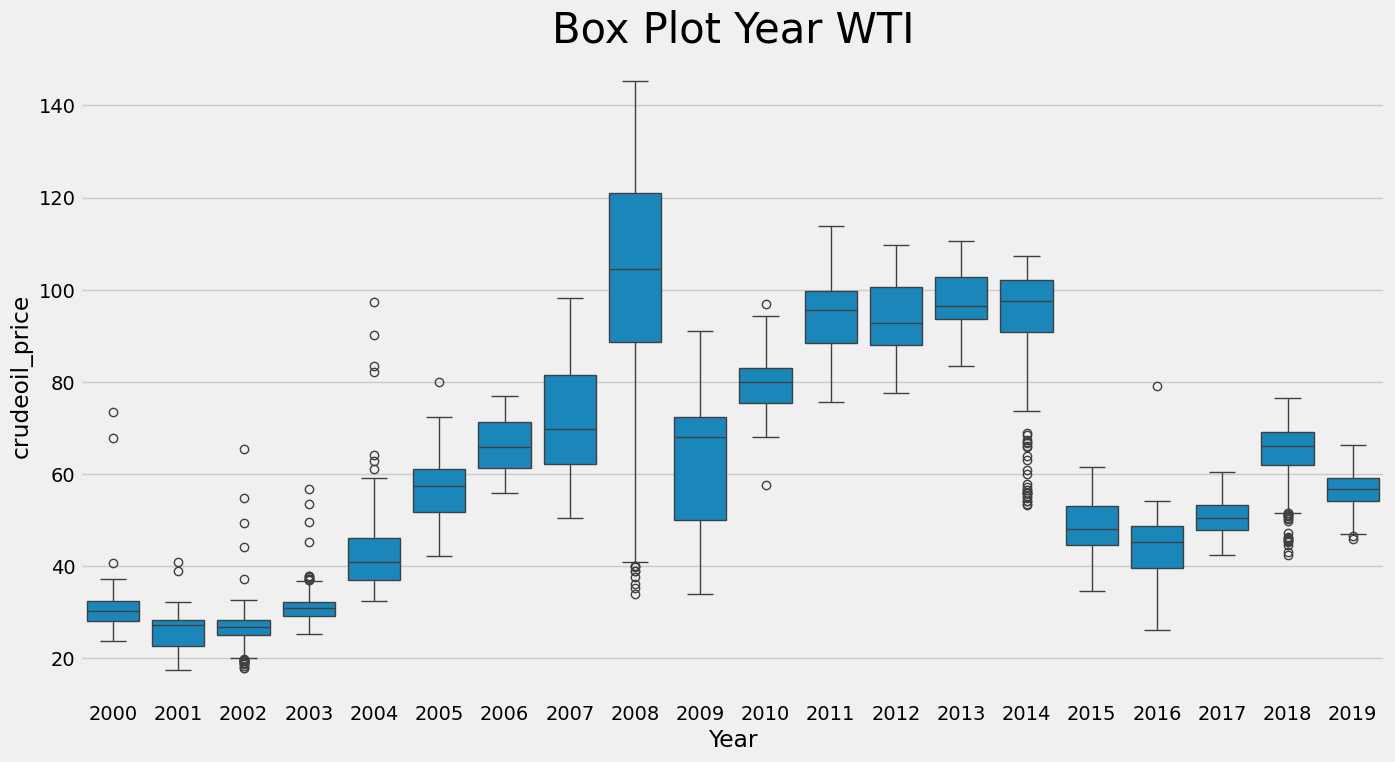

In [391]:
# Dataframe sementar
temp_data = ds_predict
temp_data['Year'] = ds_predict.index.year
##Box Plot Year Wise WTI

plt.figure(figsize=(15,8))
ax = sns.boxplot(x=temp_data['Year'], y=temp_data['crudeoil_price'])
ax.set_title('Box Plot Year WTI',fontsize=30)

- Pada data tahun 2002, 2008, 2014, 2018, dan 2020 memperlihatkan outliers
- Berdasarkan laporan yang dilansir di portal berita nilai minus yang terjadi pada tanggal 20 dan 21 April tahun 2020 diakibatkan karena adanya suplai minyak yang berlebih. Pada bulan April 2020, harga minyak mentah mengalami penurunan yang signifikan, terutama karena pandemi COVID-19. Penurunan ini terjadi karena pandemi menyebabkan banyak negara menerapkan lockdown, yang mengakibatkan penurunan permintaan minyak secara drastis.

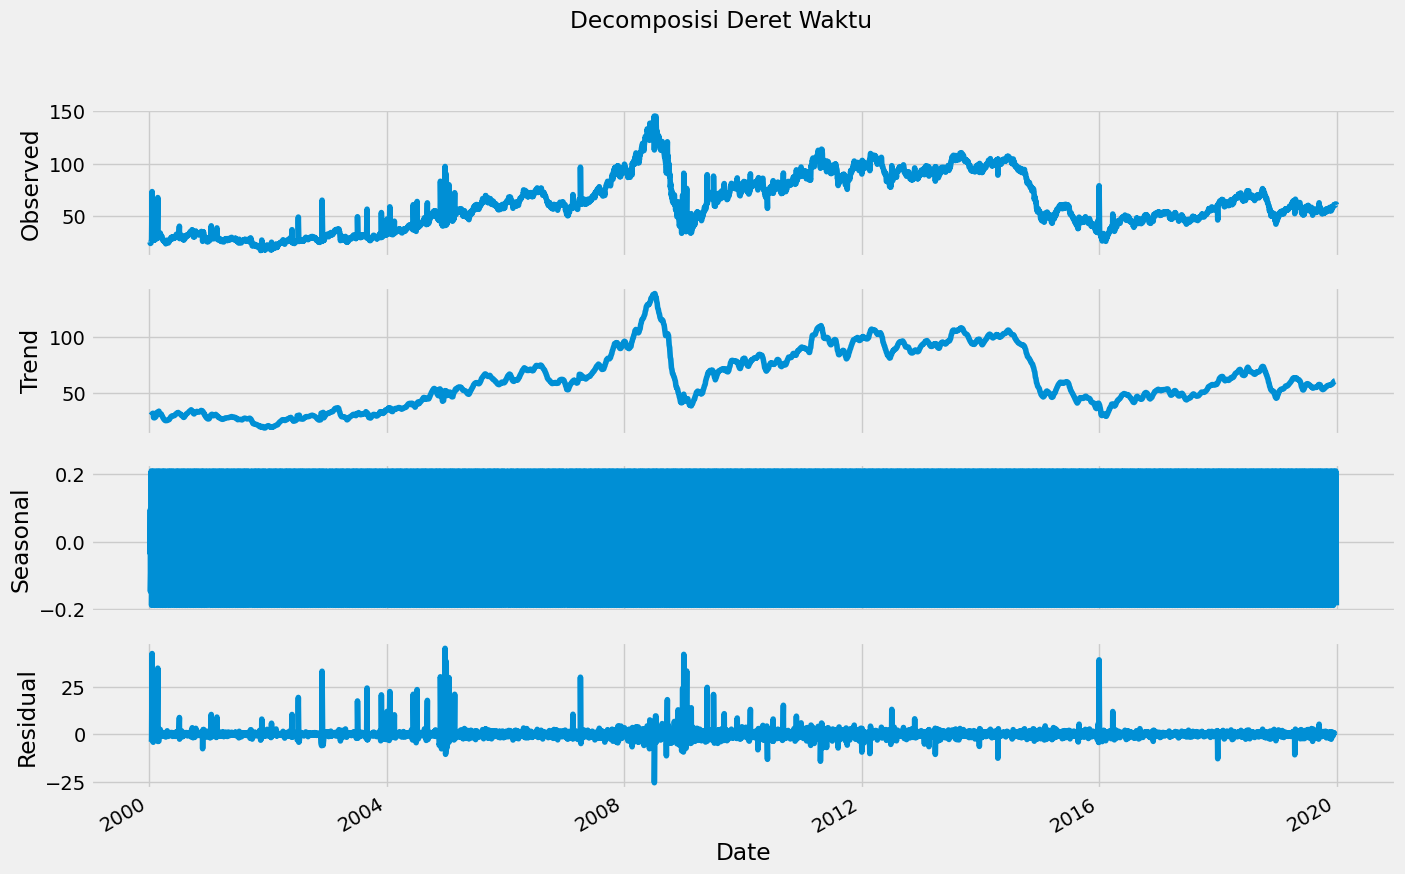

In [392]:
# Seasonality decomposition
cop = ds_predict[['crudeoil_price']].copy()

decompose_result= seasonal_decompose(cop, model='additive', period=12)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
decompose_result.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observed')
decompose_result.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
decompose_result.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Seasonal')
decompose_result.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Residual')
plt.suptitle('Decomposisi Deret Waktu')
plt.show()


Komponen Dekomposisi Deret Waktu

Tren: Komponen ini menangkap pergerakan data jangka panjang, seperti tren naik atau turun dari waktu ke waktu.
Musiman: Komponen ini menangkap pola berulang dalam periode waktu tertentu, seperti pola harian, mingguan, bulanan, atau tahunan.
Residual: Komponen ini mewakili fluktuasi data yang tersisa dan tidak dijelaskan oleh tren dan musimian.

Dari gambar di atas, harga minyak mentah dunia memiliki trend yang cenderung fluktuatif dan memiliki musiman yang sangat rapat dan dan tidak menunjukkan variasi yang jelas. Hal ini kemungkinan dapat disebabkan karena adanya outlier.

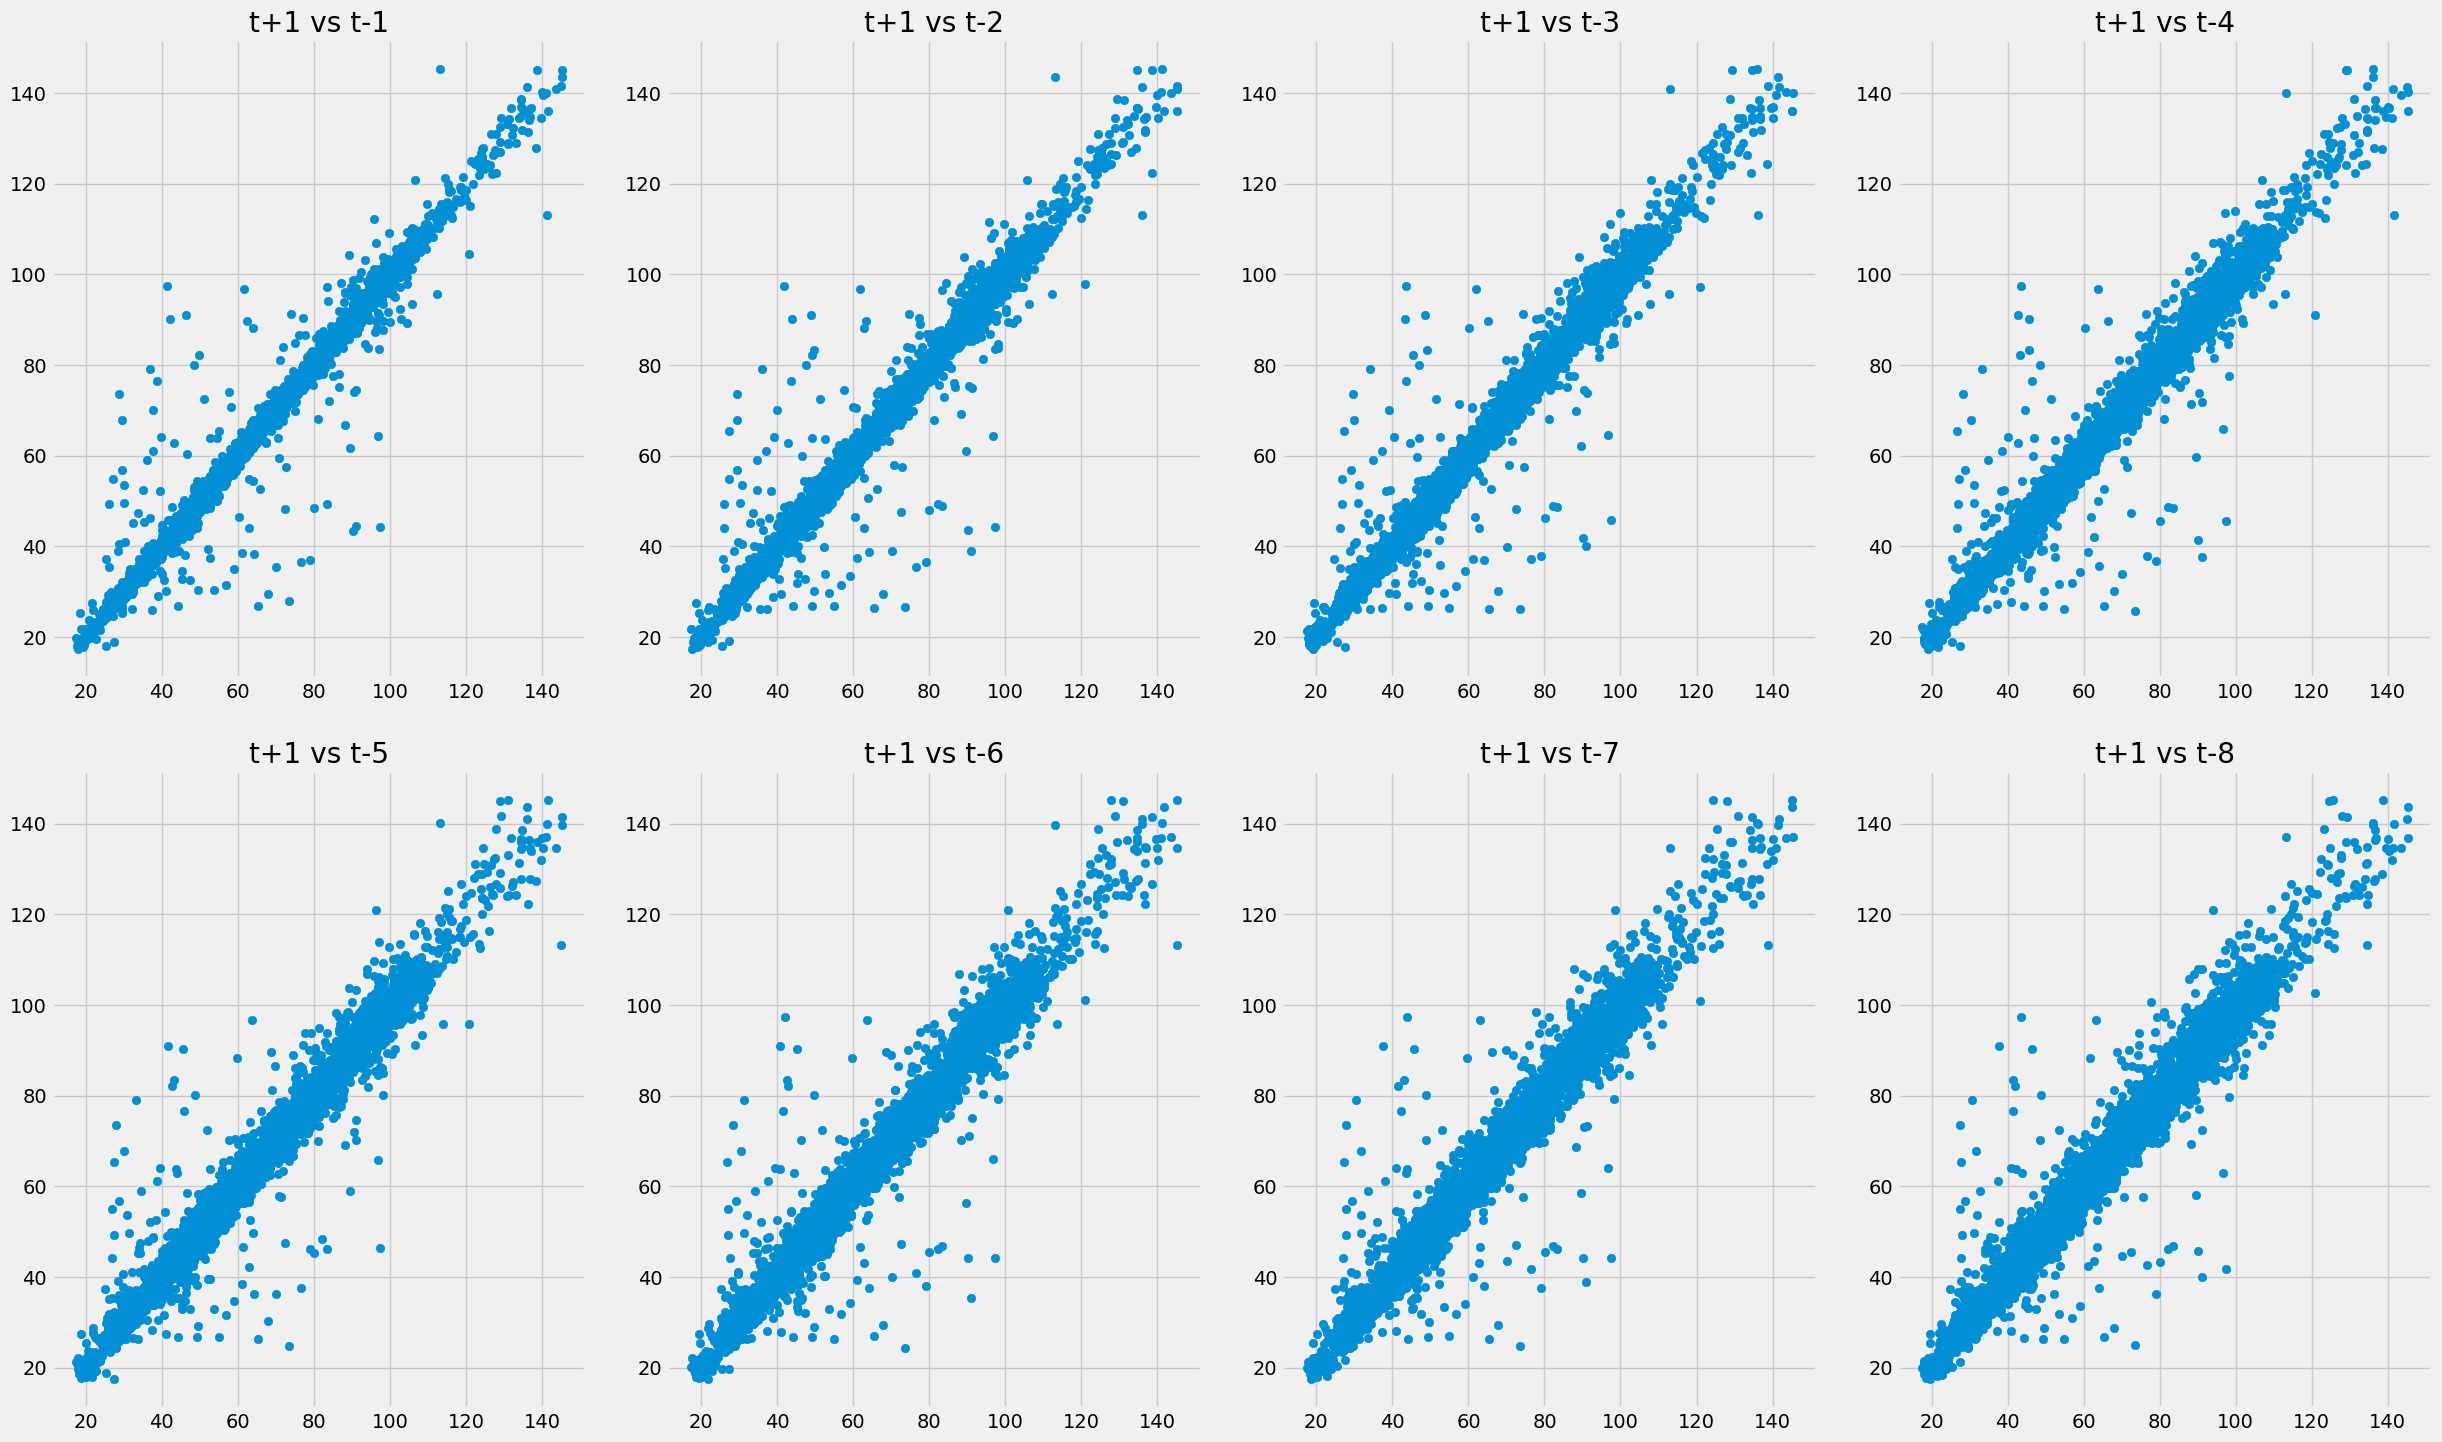

In [393]:
# Mengecek Series Lag

plt.figure(figsize=(25,15))
#pd.plotting.lag_plot(crudeoil_dsc['Price'])
#plt.show()


price_series = ds_predict['crudeoil_price']
n_lags = 8
cols = [price_series]
for i in range(1,(n_lags + 1)):
	cols.append(price_series.shift(i))

df = pd.concat(cols, axis=1)
cols = ['t+1']
for i in range(1,(n_lags + 1)):
	cols.append('t-' + str(i))
df.columns = cols

plt.figure(1)
for i in range(1,(n_lags + 1)):
	ax = plt.subplot(240 + i)
	ax.set_title('t+1 vs t-' + str(i))
	plt.scatter(x=df['t+1'].values, y=df['t-'+str(i)].values)
plt.tight_layout(pad=2)
plt.show()


Pada semua plot lag (t+1 vs t-1, t+1 vs t-2, dst.), terlihat bahwa terdapat garis diagonal yang jelas dengan penyebaran titik-titik yang sangat rapat di sepanjang garis tersebut.

Hal ini menunjukkan bahwa terdapat autokorelasi yang sangat kuat antara harga minyak mentah pada satu periode dengan periode sebelumnya. Dengan kata lain, harga minyak pada suatu waktu (t) sangat berkorelasi dengan harga pada periode sebelumnya (t-1, t-2, dst.).

Meskipun sebagian besar titik mengikuti garis diagonal, ada beberapa titik yang menyebar di bawah dan di atas garis tersebut, terutama untuk lag yang lebih panjang (t+1 vs t-7, t+1 vs t-8).
Penyebaran ini menunjukkan adanya beberapa outlier atau kejadian tidak biasa dalam data yang mungkin disebabkan oleh peristiwa global atau fluktuasi pasar yang tidak terduga.

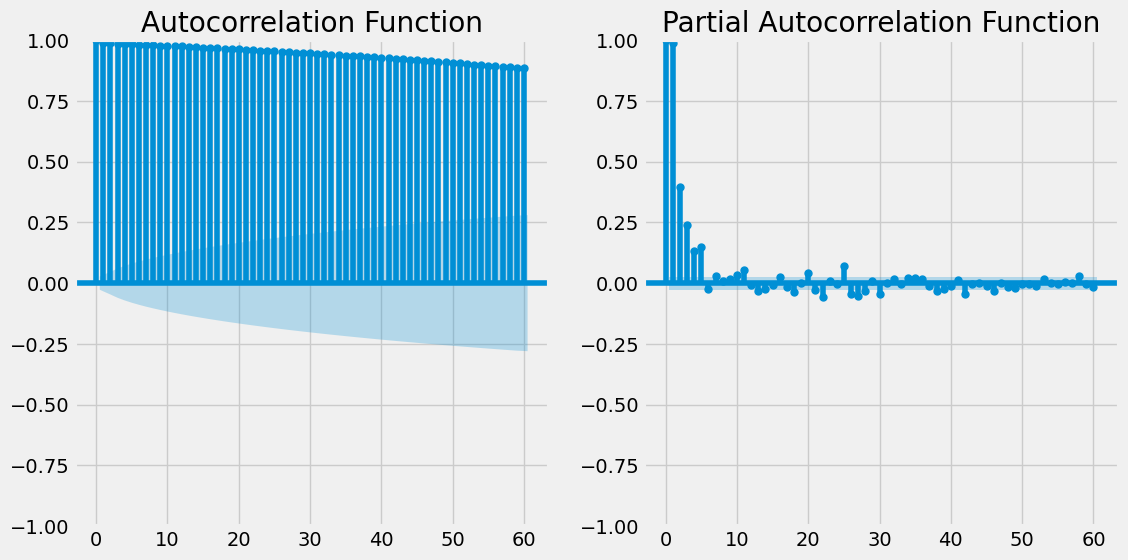

In [394]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(price_series, lags=60, ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(price_series, lags=60, ax=plt.gca())
plt.title('Partial Autocorrelation Function')

plt.show()

Plot fungsi ACF menunjukkan korelasi waktu dengan lagnya. Batang ACF meluas hingga lag-60 menunjukkan korelasi signifikan pada beberapa lag yang menunjukkan bahwa deret tersebut tidak stasioner.
Plot fungsi PACF menunjukkan korelasi waktu dengan lagnya dan menghilangkan batang lagnya.

## Bivariate Analysis (Antara harga minyak mentah dengan feature lainnya)

In [395]:
ds_predict.drop(labels=['Year'], axis=1, inplace=True)

In [396]:
#Scaling data untuk analisa bivariate
scdata = MinMaxScaler(feature_range=(0,1))
ds_predict_scaled = scdata.fit_transform(ds_predict)

In [397]:
# Scaled data glimpse

ds_predict_scaled[:2]

array([[0.01657188, 0.23182592, 0.58664515, 0.06336045],
       [0.01559347, 0.23269178, 0.58603994, 0.05835419]])

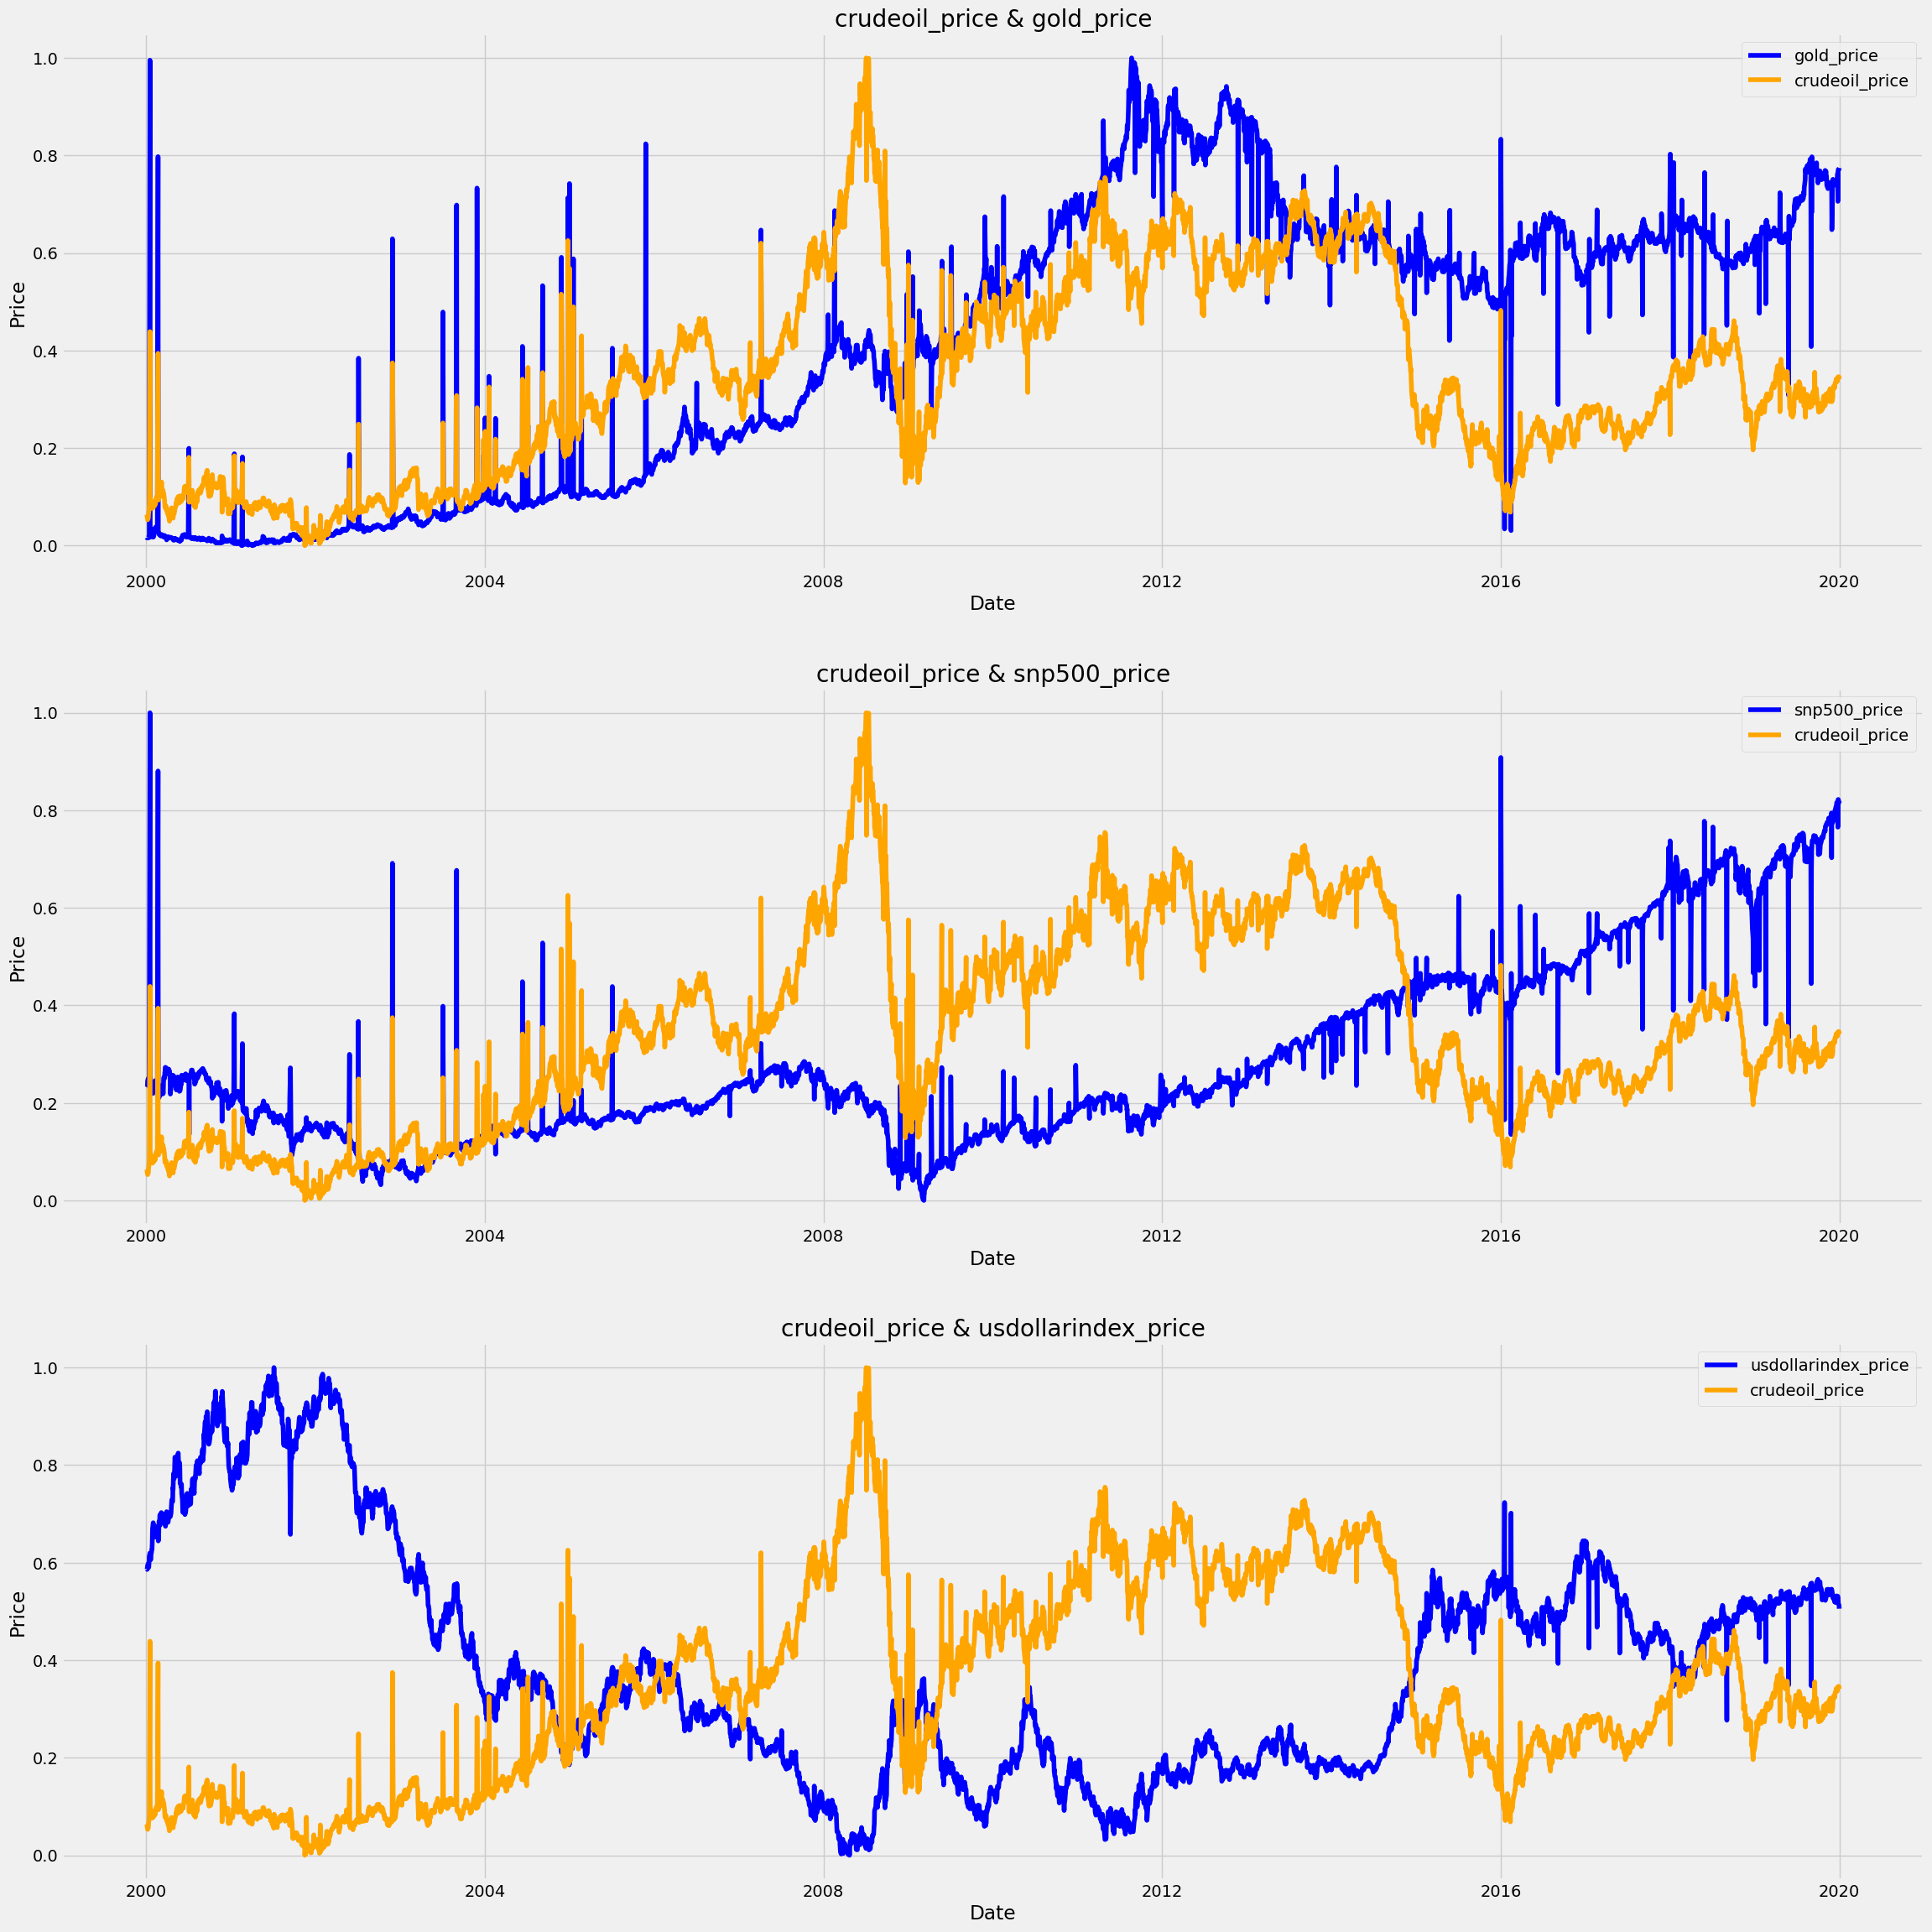

In [398]:
# Membandingkan pergerakan harga minyak mentah dengan variabel lainnya
col_names = ds_predict.columns[:-1]
scaled_features = ds_predict_scaled[:,:-1]
fig = plt.figure(figsize=(24, 24))
plt.style.use('fivethirtyeight')
for i in range(3):
  ax = fig.add_subplot(3,1,i+1)
  ax.plot(ds_predict.index,scaled_features[:,i],label=col_names[i],c='blue')
  ax.plot(ds_predict.index,ds_predict_scaled[:,3],label='crudeoil_price',c='orange')
  ax.set_title('crudeoil_price & ' + col_names[i])
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
fig.tight_layout(pad=3.0)
plt.show()

Gambar di atas merupakan perbandingan harga antara harga minyak mentah dengan variabel lainnya.


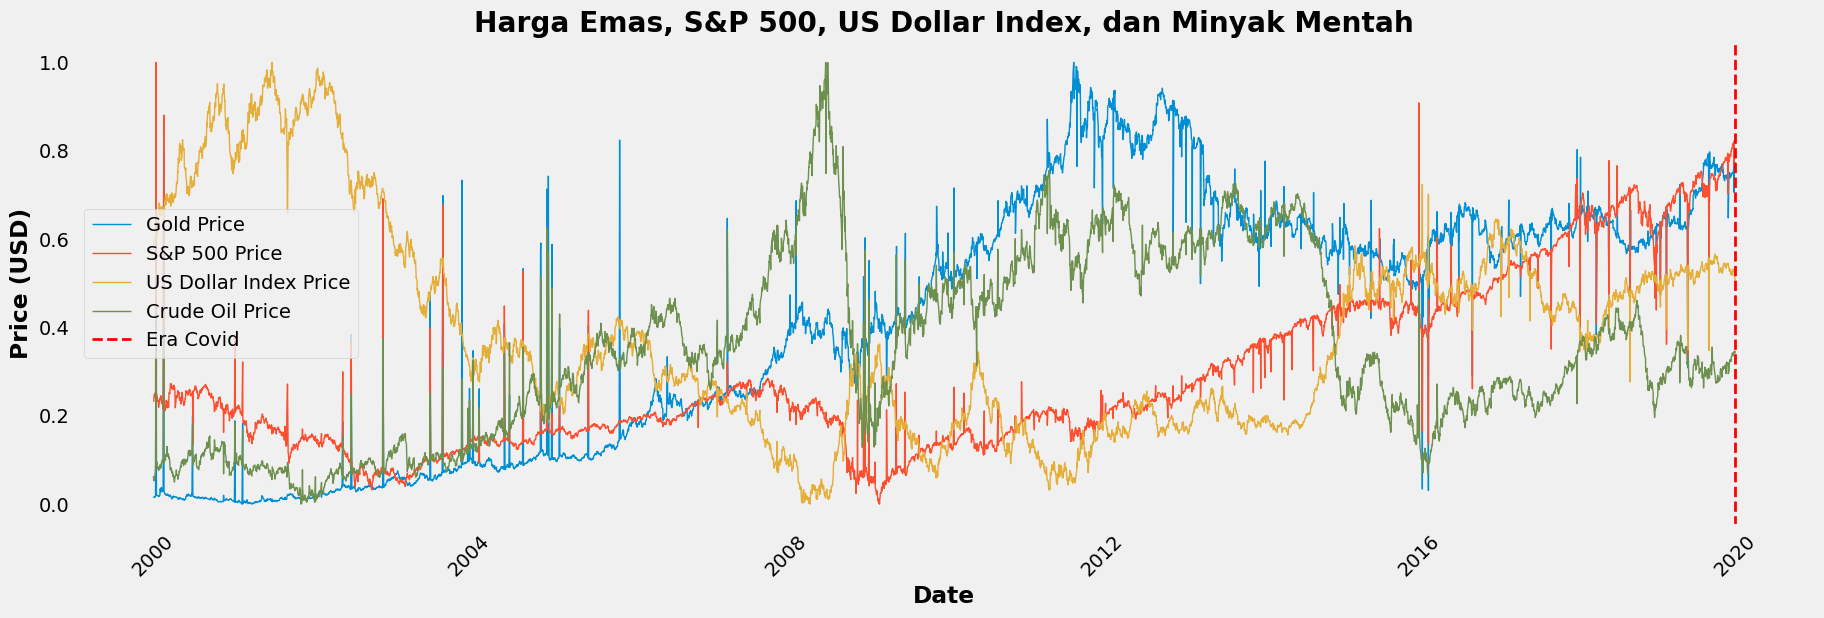

In [399]:
cop1= ds_predict_scaled.copy()
plt.figure(figsize = (20,6))

# Plot harga emas, snp500, us dollar, dan minyak mentah
plt.plot(ds_predict.index, cop1[:, 0], label='Gold Price', linewidth=1)
plt.plot(ds_predict.index, cop1[:, 1], label='S&P 500 Price', linewidth=1)
plt.plot(ds_predict.index, cop1[:, 2], label='US Dollar Index Price', linewidth=1)
plt.plot(ds_predict.index, cop1[:, 3], label='Crude Oil Price', linewidth=1)

# Highlight Era Covid dimulai pada tahun 2020
plt.axvline(pd.Timestamp('2020-01-01'), color='r', linestyle='--', linewidth=2, label='Era Covid')

plt.legend()
plt.grid()
plt.title('Harga Emas, S&P 500, US Dollar Index, dan Minyak Mentah', fontweight='bold')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Price (USD)', fontweight='bold')

# Rotate date labels for better readability
plt.xticks(rotation=45)

plt.show()

### Eliminasi Ouliers

In [400]:
#Uji Korelasi
ds_predict.corr(method='spearman')

gold_price  snp500_price  usdollarindex_price  \
gold_price             1.000000      0.532857            -0.479343   
snp500_price           0.532857      1.000000             0.136923   
usdollarindex_price   -0.479343      0.136923             1.000000   
crudeoil_price         0.676798      0.216278            -0.847952   

                     crudeoil_price  
gold_price                 0.676798  
snp500_price               0.216278  
usdollarindex_price       -0.847952  
crudeoil_price             1.000000

In [401]:
#Feature Selection
after_fs = ds_predict[['crudeoil_price']]
after_fs.head(5)

crudeoil_price
Date                      
2000-01-04           25.55
2000-01-05           24.91
2000-01-06           24.78
2000-01-07           24.22
2000-01-10           24.67

#### Zscore Teknik

In [402]:
zscore = np.abs(zs(after_fs['crudeoil_price']))
ds_predict_zscore = after_fs.copy()
ds_predict_zscore['zscore'] = zscore
ds_predict_zscore.head(5)

crudeoil_price    zscore
Date                                
2000-01-04           25.55  1.399587
2000-01-05           24.91  1.424116
2000-01-06           24.78  1.429098
2000-01-07           24.22  1.450561
2000-01-10           24.67  1.433314

In [403]:
##Considering Outliers of more than +-2.5 zscore as outliers
len(ds_predict_zscore[ds_predict_zscore['zscore']>2.5])

42

Eliminasi Outliers
Z-score mengukur seberapa jauh nilai individu dalam dataset dari mean dalam satuan standar deviasi. Jika Z-score suatu nilai sangat tinggi atau sangat rendah, nilai tersebut dapat dianggap sebagai outlier.

In [404]:
ds_predict_zscore = ds_predict_zscore.loc[ds_predict_zscore['zscore']<2.5, ['crudeoil_price']]
ds_predict_zscore = ds_predict_zscore.sort_values(by='Date', ascending=True)
ds_predict_zscore.shape

(5151, 1)

In [405]:
# Cek Keakuratan data : Memastikan bahwa data tersebut akurat dan sesuai dengan realita
# Contoh sederhana: memeriksa nilai negatif pada kolom yang tidak seharusnya negatif
ds_predict_list = ['crudeoil_price']
nilai_negatif = ds_predict_zscore[ds_predict_list] < 0
total_nn = nilai_negatif.sum().sum()


for index, row in ds_predict_zscore.iterrows():
    for col_index, value in enumerate(row[ds_predict_list]):
        if nilai_negatif.loc[index, ds_predict_list[col_index]]:
         print(f"Nilai negatif ditemukan di kolom '{ds_predict_list[col_index]}': {value}, pada tanggal '{index}'")

# Print a summary message
print("\nTotal nilai negatif ditemukan:", nilai_negatif.sum().sum())


Total nilai negatif ditemukan: 0


### Data Preparasi untuk Modelling

Time Series Cross Validation

In [406]:
dataset = ds_predict_zscore
dataset

crudeoil_price
Date                      
2000-01-04           25.55
2000-01-05           24.91
2000-01-06           24.78
2000-01-07           24.22
2000-01-10           24.67
...                    ...
2019-12-25           61.19
2019-12-26           61.68
2019-12-27           61.72
2019-12-30           61.68
2019-12-31           61.06

[5151 rows x 1 columns]

In [407]:
tscv = TimeSeriesSplit(n_splits = 5, test_size = None, gap=0)
dataset = dataset.sort_index()

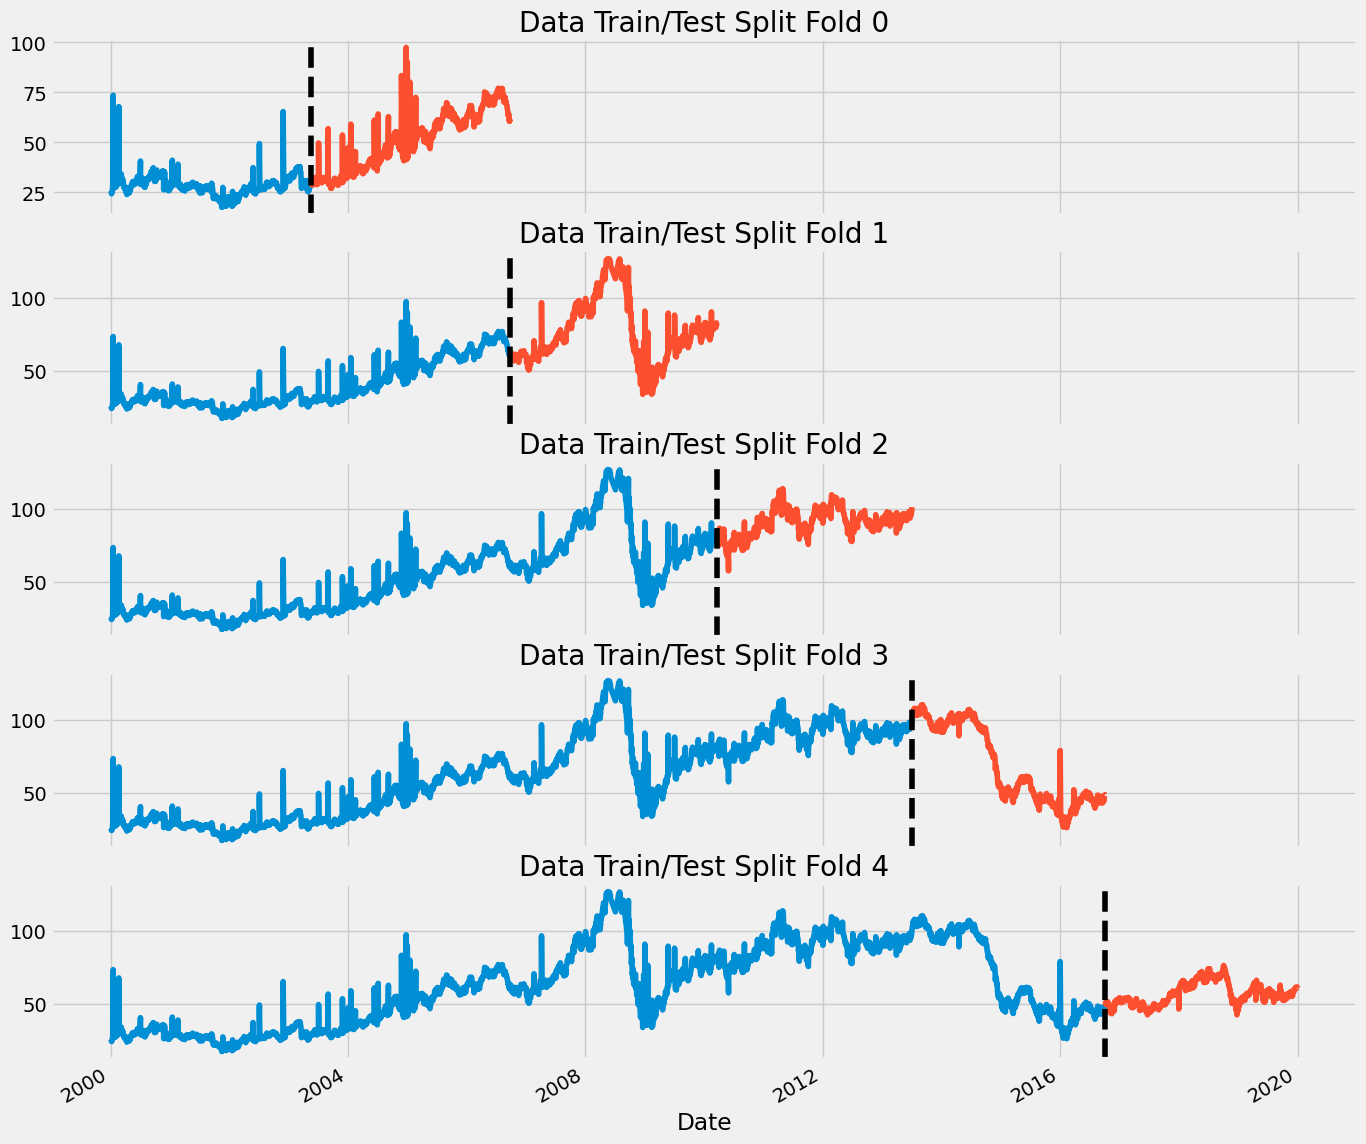

In [408]:
fig, axs = plt.subplots(5,1, figsize=(15,15), sharex=True)

fold = 0
for train_index, val_index in tscv.split(dataset):
    train = dataset.iloc[train_index]
    test = dataset.iloc[val_index]
    train['crudeoil_price'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['crudeoil_price'].plot(ax=axs[fold], label='Train')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold +=1
plt.show()    
        

In [409]:
#Scaling Data
scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

In [410]:
dataset = pd.DataFrame(dataset_scaled)
dataset

0
0     0.073905
1     0.068066
2     0.066880
3     0.061770
4     0.065876
...        ...
5146  0.399088
5147  0.403558
5148  0.403923
5149  0.403558
5150  0.397901

[5151 rows x 1 columns]

In [411]:
dataset.shape

(5151, 1)

LSTM MODELS

In [412]:
#Train Using Cross Validation
tscv = TimeSeriesSplit(n_splits = 5, test_size = None , gap=0)

fold = 0
preds = []
scores = []
for train_index, val_index in tscv.split(dataset):

    X_train = data_input.iloc[train_index]
    X_val = data_input.iloc[val_index]
    y_train = dataset.iloc[train_index]
    y_val = dataset.iloc[val_index]

    # Menambahkan dimensi untuk input LSTM
    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)
    y_train = np.expand_dims(y_train, axis=2)
    y_val = np.expand_dims(y_val, axis=2)

    model_lstm = Sequential()
    model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))#, input_shape=(X_train.shape[1], 3)))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(units=50))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    model_lstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mae'] )

    history = model_lstm.fit(X_train, y_train, epochs=180, batch_size=8, validation_split=0.2) 

    score = model_lstm.evaluate(X_val, y_val)
    scores.append(score)


Epoch 1/180
86/86 [==============================] - 44s 173ms/step - loss: 0.0033 - mae: 0.0414 - val_loss: 0.0028 - val_mae: 0.0348
Epoch 2/180
86/86 [==============================] - 2s 19ms/step - loss: 0.0021 - mae: 0.0332 - val_loss: 0.0025 - val_mae: 0.0325
Epoch 3/180
86/86 [==============================] - 2s 25ms/step - loss: 0.0021 - mae: 0.0323 - val_loss: 0.0028 - val_mae: 0.0350
Epoch 4/180
86/86 [==============================] - 2s 20ms/step - loss: 0.0021 - mae: 0.0315 - val_loss: 0.0025 - val_mae: 0.0323
Epoch 5/180
86/86 [==============================] - 2s 25ms/step - loss: 0.0021 - mae: 0.0324 - val_loss: 0.0027 - val_mae: 0.0345
Epoch 6/180
86/86 [==============================] - 2s 20ms/step - loss: 0.0020 - mae: 0.0312 - val_loss: 0.0026 - val_mae: 0.0337
Epoch 7/180
86/86 [==============================] - 2s 19ms/step - loss: 0.0020 - mae: 0.0305 - val_loss: 0.0026 - val_mae: 0.0332
Epoch 8/180
86/86 [==============================] - 2s 28ms/step - loss: 

In [413]:

print("Cross-validation scores:", scores)

# Define the folder path
folder_path = "model"

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Save the model as a .h5 file
model_save_path_h5 = os.path.join(folder_path, "crude-oil-lstm-fix2.h5")
model_lstm.save(model_save_path_h5)
print(f"Model saved to {model_save_path_h5}")

# Save the model as a .pkl file
model_save_path_pkl = os.path.join(folder_path, "crude-oil-lstm-fix2.pkl")
with open(model_save_path_pkl, 'wb') as f:
    pickle.dump(model_lstm, f)
print(f"Model saved to {model_save_path_pkl}")

# Load the .h5 model
loaded_model_h5 = load_model(model_save_path_h5)
print(f"Model loaded from {model_save_path_h5}")

# Recompile the loaded .h5 model
loaded_model_h5.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Load the .pkl model
with open(model_save_path_pkl, 'rb') as f:
    loaded_model_pkl = pickle.load(f)
print(f"Model loaded from {model_save_path_pkl}")

# Recompile the loaded .pkl model
loaded_model_pkl.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

Cross-validation scores: [[0.047948580235242844, 0.18684253096580505], [0.012673350051045418, 0.08388439565896988], [0.012147451750934124, 0.09165287762880325], [0.027110382914543152, 0.14903633296489716], [0.04040750861167908, 0.19262459874153137]]


c:\Users\Rizal\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to model\crude-oil-lstm-fix2.h5
Model saved to model\crude-oil-lstm-fix2.pkl
Model loaded from model\crude-oil-lstm-fix2.h5
Model loaded from model\crude-oil-lstm-fix2.pkl


In [414]:
model_lstm.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_104 (LSTM)             (None, 3, 50)             10400     
                                                                 
 dropout_156 (Dropout)       (None, 3, 50)             0         
                                                                 
 lstm_105 (LSTM)             (None, 3, 50)             20200     
                                                                 
 dropout_157 (Dropout)       (None, 3, 50)             0         
                                                                 
 lstm_106 (LSTM)             (None, 3, 50)             20200     
                                                                 
 dropout_158 (Dropout)       (None, 3, 50)             0         
                                                                 
 lstm_107 (LSTM)             (None, 50)              

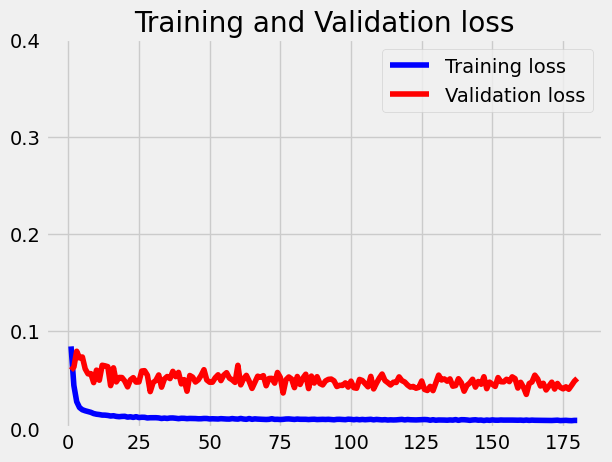

In [415]:
# viz loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# train - validation loss 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4])

plt.legend()
plt.show()

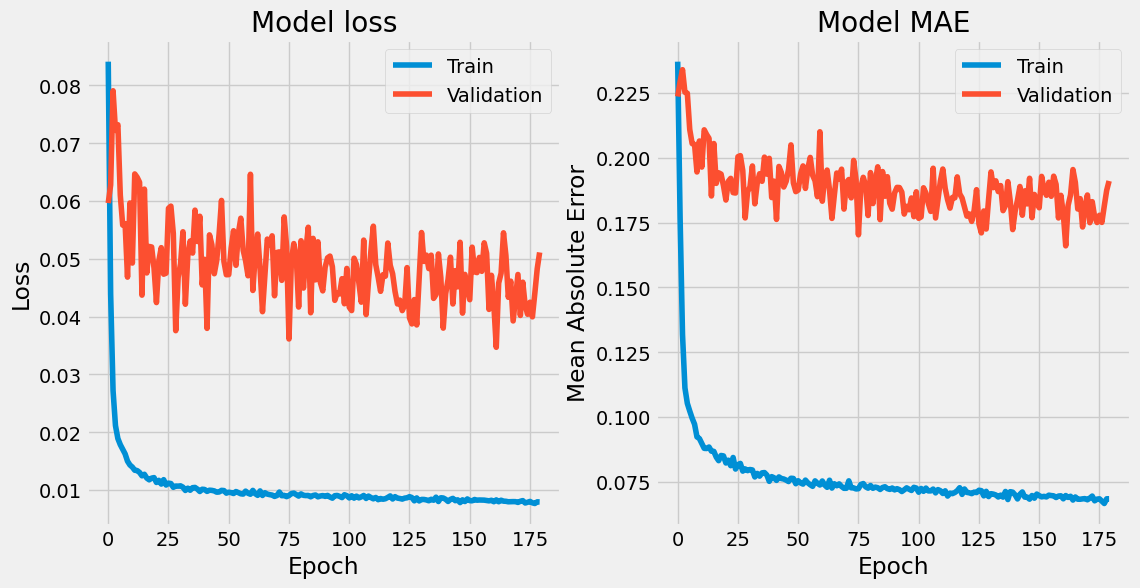

In [416]:
import matplotlib.pyplot as plt

# Plot learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation MAE values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.show()

# Call the function with the training history
plot_learning_curves(history)


In [417]:
# Evaluasi menggunakan data validasi
train_predict=model_lstm.predict(X_train)
train_predict = np.squeeze(train_predict)  # Menghapus dimensi ekstra
X_train = np.squeeze(X_train) 

135/135 [==============================] - 8s 11ms/step


In [418]:
test_predict=model_lstm.predict(y_val)
test_predict = np.squeeze(test_predict)  # Menghapus dimensi ekstra
y_val = np.squeeze(y_val) 

27/27 [==============================] - 5s 12ms/step


In [419]:
train_rmse_lstm = math.sqrt(mean_squared_error(y_train.reshape(-1), train_predict))
test_rmse_lstm = math.sqrt(mean_squared_error(y_val.reshape(-1), test_predict))

train_mse_lstm = math.sqrt(mean_squared_error(y_train.reshape(-1), train_predict))
test_mse_lstm = math.sqrt(mean_squared_error(y_val.reshape(-1), test_predict))

train_mae_lstm = math.sqrt(mean_absolute_error(y_train.reshape(-1), train_predict))
test_mae_lstm = math.sqrt(mean_absolute_error(y_val.reshape(-1), test_predict))

r2_score_val = r2_score(y_val.reshape(-1), test_predict)


print("train rmse: ", round(train_rmse_lstm, 3))
print("test rmse: ", round(test_rmse_lstm, 3))

print("train mse: ", round(train_mse_lstm, 3))
print("test mse: ", round(test_mse_lstm, 3))

print("train mae: ", round(train_mae_lstm, 3))
print("test mae: ", round(test_mae_lstm, 3))

print("R2 Score: ", round(r2_score_val, 3))


train rmse:  0.123
test rmse:  0.059
train mse:  0.123
test mse:  0.059
train mae:  0.295
test mae:  0.218
R2 Score:  0.282


In [420]:
y_train.reshape(-1)

array([0.07390511, 0.06806569, 0.06687956, ..., 0.28093066, 0.28613139,
       0.2850365 ])

In [421]:
# transformback to original form
train_predict=scaler.inverse_transform(train_predict.reshape(-1,1))
test_predict=scaler.inverse_transform(test_predict.reshape(-1,1))

In [422]:
dataset2 = ds_predict_zscore
dataset2

crudeoil_price
Date                      
2000-01-04           25.55
2000-01-05           24.91
2000-01-06           24.78
2000-01-07           24.22
2000-01-10           24.67
...                    ...
2019-12-25           61.19
2019-12-26           61.68
2019-12-27           61.72
2019-12-30           61.68
2019-12-31           61.06

[5151 rows x 1 columns]

In [423]:
train_predict_df = pd.DataFrame(train_predict)
train_predict_df = train_predict_df[[0]]
train_predict_df.columns = ["Predict Price with LSTM Model"]

train_date = dataset2.reset_index(drop=False)
train_date = train_date[62:len(train_predict_df)]
train_date = train_date["Date"].reset_index(drop=True)

train_predict_df.insert(0, "Date", train_date)
train_predict_df.set_index("Date", inplace=True)
train_predict_df = train_predict_df[0:-62]

train_predict_df

Predict Price with LSTM Model
Date                                     
2000-03-30                      36.479137
2000-03-31                      36.467125
2000-04-03                      36.364380
2000-04-04                      36.926601
2000-04-05                      37.077991
...                                   ...
2016-09-28                      78.855232
2016-09-29                      79.377090
2016-09-30                      79.001251
2016-10-03                      78.501251
2016-10-04                      78.603821

[4231 rows x 1 columns]

In [424]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_df = test_predict_df[[0]]
test_predict_df.columns = ["Predict Price with LSTM Model"]

test_date = dataset2.reset_index(drop=False)
test_date = test_date[len(train_date)+62:]
test_date = test_date["Date"].reset_index(drop=True)

test_predict_df.insert(0, "Date", test_date)
test_predict_df.set_index("Date", inplace=True)
test_predict_df = test_predict_df[0:-62]

test_predict_df

Predict Price with LSTM Model
Date                                     
2016-10-05                      54.185787
2016-10-06                      54.291672
2016-10-07                      54.182316
2016-10-10                      54.449867
2016-10-11                      54.352486
...                                   ...
2019-09-30                      54.924297
2019-10-01                      54.845642
2019-10-02                      54.674580
2019-10-03                      54.641449
2019-10-04                      54.704231

[796 rows x 1 columns]

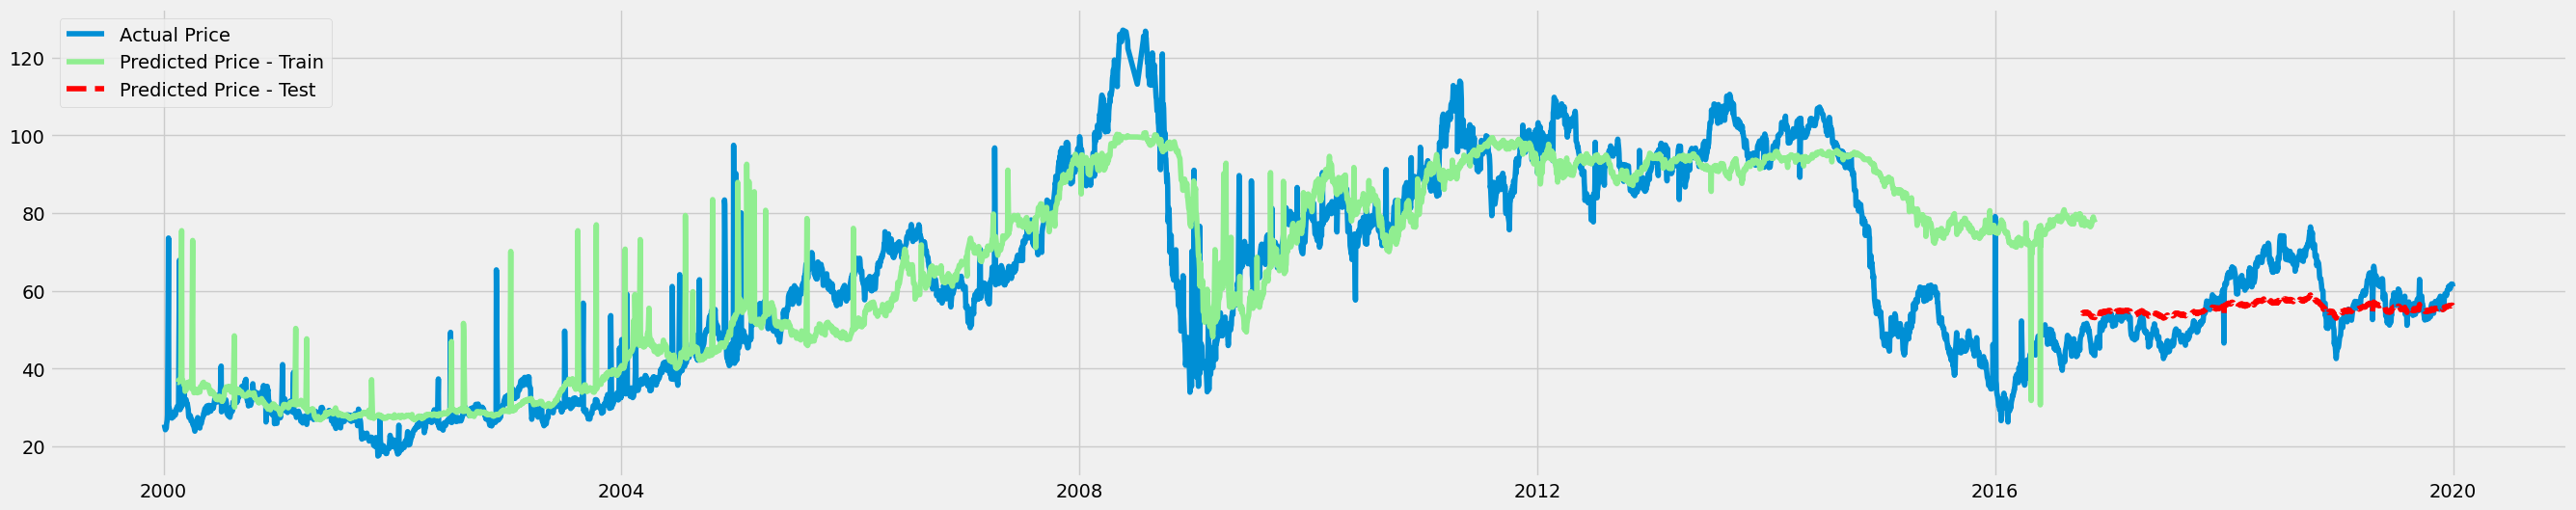

In [425]:
time_step=30
# Plot the actual prices
plt.figure(figsize=(30, 6))
ax = plt.subplot(111)
ax.plot(dataset2.index, dataset2['crudeoil_price'], label='Actual Price')

# Plot the predicted prices for the training dataset
ax.plot(dataset2.index[time_step:len(train_predict) + time_step], train_predict.reshape(-1), label='Predicted Price - Train', color='lightgreen')

# Plot the predicted prices for the test dataset
ax.plot(dataset2.index[-len(test_predict):], test_predict.reshape(-1), label='Predicted Price - Test', color='r', linestyle='dashed')

plt.legend(loc='upper left')
plt.show()

In [426]:
import time
import datetime
from datetime import date, timedelta

# predict using last 30 days data
input_price = val_index[-60:].reshape((60, 1))
yhat = model_lstm.predict(input_price, verbose=0)

# transformback to original form
new_predict=scaler.inverse_transform(yhat)

# store to dataframe
prices = []
today_date = date.today()
day = pd.date_range(start=today_date, periods=1)

for i in new_predict[0]:
        prices.append(i)

new_df = pd.DataFrame(prices)
new_df.insert(0, "Date", day)
new_df = new_df.rename(columns={0:"PredictPrice"})
new_df["PredictPrice"] = new_df["PredictPrice"]

new_df.sort_index(inplace=True)
new_df = new_df.set_index(pd.DatetimeIndex(new_df["Date"])) # set index using date
new_df.drop(columns="Date", inplace=True) # drop date column since already have datetimeindex
new_df.columns = ["crudeoil_price"] # rename column

prices_df = dataset2[["crudeoil_price"]].copy() # copy hist dataset
new_rows = new_df[["crudeoil_price"]] # take forecasted prices
prices_df = pd.concat([dataset2, new_df])  # append historical + future prices

prices_df.tail(10)


crudeoil_price
Date                      
2019-12-19       61.220000
2019-12-20       60.440000
2019-12-23       60.520000
2019-12-24       61.110000
2019-12-25       61.190000
2019-12-26       61.680000
2019-12-27       61.720000
2019-12-30       61.680000
2019-12-31       61.060000
2024-07-27       53.039612

GRU

In [427]:
#Train Using Cross Validation
tscv = TimeSeriesSplit(n_splits = 5, test_size = None, gap=0)

fold = 0
preds2 = []
scores2 = []
for train_index, val_index in tscv.split(dataset):

    X_train2 = data_input.iloc[train_index]
    X_val2 = data_input.iloc[val_index]
    y_train2 = dataset.iloc[train_index]
    y_val2 = dataset.iloc[val_index]

    # Menambahkan dimensi untuk input LSTM
    X_train2 = np.expand_dims(X_train2, axis=2)
    X_val2 = np.expand_dims(X_val2, axis=2)
    y_train2 = np.expand_dims(y_train2, axis=2)
    y_val2 = np.expand_dims(y_val2, axis=2)

    model_gru = Sequential()
    model_gru.add(GRU(units=32, return_sequences=True, input_shape=(X_train2.shape[1], 1)))#, input_shape=(X_train.shape[1], 3)))
    model_gru.add(Dropout(0.2))
    model_gru.add(GRU(units=32, return_sequences=True, input_shape=(X_train2.shape[1], 1)))
    model_gru.add(Dropout(0.2))
    model_gru.add(GRU(units=32, return_sequences=True, input_shape=(X_train2.shape[1], 1)))
    model_gru.add(Dropout(0.2))
    model_gru.add(GRU(units=32))
    model_gru.add(Dropout(0.2))
    model_gru.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    model_gru.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mae'] )

    history2 = model_gru.fit(X_train2, y_train2, epochs=180, batch_size=8, validation_split=0.2)

    score2 = model_gru.evaluate(X_val2, y_val2)
    scores2.append(score2)


Epoch 1/180
86/86 [==============================] - 23s 65ms/step - loss: 0.0173 - mae: 0.1007 - val_loss: 0.0031 - val_mae: 0.0377
Epoch 2/180
86/86 [==============================] - 2s 19ms/step - loss: 0.0074 - mae: 0.0690 - val_loss: 0.0027 - val_mae: 0.0337
Epoch 3/180
86/86 [==============================] - 2s 22ms/step - loss: 0.0060 - mae: 0.0598 - val_loss: 0.0027 - val_mae: 0.0343
Epoch 4/180
86/86 [==============================] - 1s 17ms/step - loss: 0.0051 - mae: 0.0566 - val_loss: 0.0029 - val_mae: 0.0364
Epoch 5/180
86/86 [==============================] - 1s 17ms/step - loss: 0.0046 - mae: 0.0529 - val_loss: 0.0029 - val_mae: 0.0360
Epoch 6/180
86/86 [==============================] - 2s 28ms/step - loss: 0.0045 - mae: 0.0511 - val_loss: 0.0024 - val_mae: 0.0317
Epoch 7/180
86/86 [==============================] - 1s 17ms/step - loss: 0.0039 - mae: 0.0480 - val_loss: 0.0031 - val_mae: 0.0377
Epoch 8/180
86/86 [==============================] - 2s 22ms/step - loss: 0

In [428]:

print("Cross-validation scores:", scores2)

# Define the folder path
folder_path = "model"

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Save the model as a .h5 file
model_save_path_h5 = os.path.join(folder_path, "crude-oil-gru-fix2.h5")
model_gru.save(model_save_path_h5)
print(f"Model saved to {model_save_path_h5}")

# Save the model as a .pkl file
model_save_path_pkl = os.path.join(folder_path, "crude-oil-gru-fix2.pkl")
with open(model_save_path_pkl, 'wb') as f:
    pickle.dump(model_gru, f)
print(f"Model saved to {model_save_path_pkl}")

# Load the .h5 model
loaded_model_h5 = load_model(model_save_path_h5)
print(f"Model loaded from {model_save_path_h5}")

# Recompile the loaded .h5 model
loaded_model_h5.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Load the .pkl model
with open(model_save_path_pkl, 'rb') as f:
    loaded_model_pkl = pickle.load(f)
print(f"Model loaded from {model_save_path_pkl}")

# Recompile the loaded .pkl model
loaded_model_pkl.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

Cross-validation scores: [[0.04654775932431221, 0.18402975797653198], [0.014877031557261944, 0.08802995830774307], [0.01255241222679615, 0.09280846267938614], [0.029936103150248528, 0.15202505886554718], [0.025848310440778732, 0.15067128837108612]]


c:\Users\Rizal\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to model\crude-oil-gru-fix2.h5
Model saved to model\crude-oil-gru-fix2.pkl
Model loaded from model\crude-oil-gru-fix2.h5
Model loaded from model\crude-oil-gru-fix2.pkl


In [429]:
model_gru.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_68 (GRU)                (None, 3, 32)             3360      
                                                                 
 dropout_176 (Dropout)       (None, 3, 32)             0         
                                                                 
 gru_69 (GRU)                (None, 3, 32)             6336      
                                                                 
 dropout_177 (Dropout)       (None, 3, 32)             0         
                                                                 
 gru_70 (GRU)                (None, 3, 32)             6336      
                                                                 
 dropout_178 (Dropout)       (None, 3, 32)             0         
                                                                 
 gru_71 (GRU)                (None, 32)              

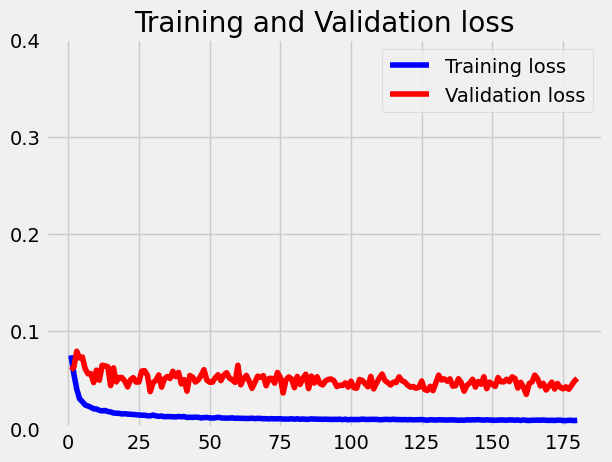

In [430]:
# viz loss
loss = history2.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# train - validation loss 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4])

plt.legend()
plt.show()

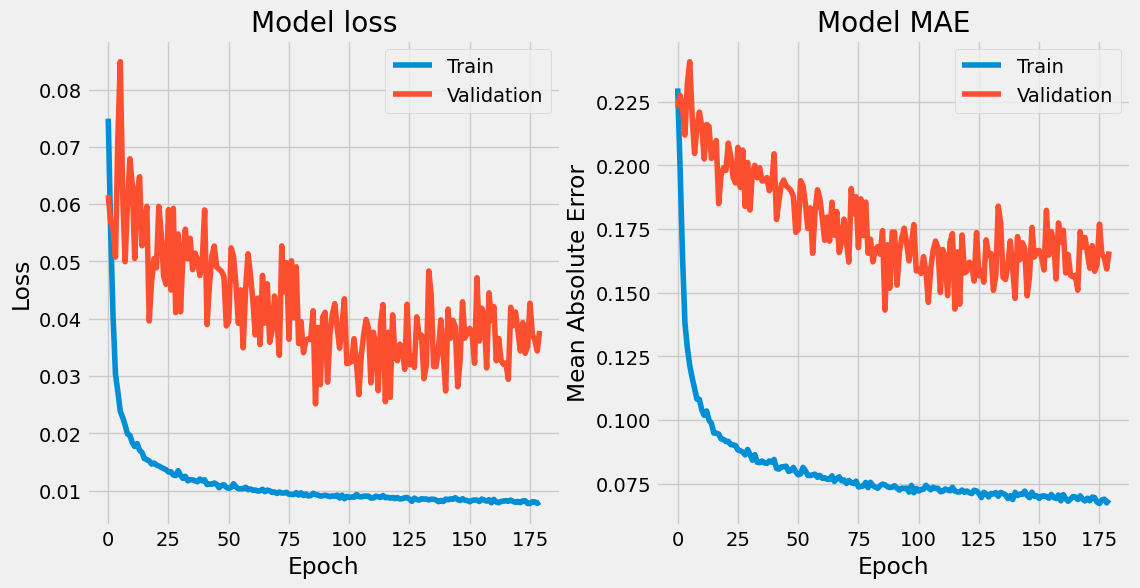

In [431]:
import matplotlib.pyplot as plt

# Plot learning curves
def plot_learning_curves(history2):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history2.history['loss'])
    plt.plot(history2.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation MAE values
    plt.subplot(1, 2, 2)
    plt.plot(history2.history['mae'])
    plt.plot(history2.history['val_mae'])
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.show()

# Call the function with the training history
plot_learning_curves(history2)


In [432]:
# Evaluasi menggunakan data validasi
train_predict_gru=model_gru.predict(X_train2)
train_predict_gru = np.squeeze(train_predict_gru)  # Menghapus dimensi ekstra
X_train2 = np.squeeze(X_train2) 

135/135 [==============================] - 13s 13ms/step


In [433]:
test_predict_gru=model_gru.predict(y_val2)
test_predict_gru = np.squeeze(test_predict_gru)  # Menghapus dimensi ekstra
y_val2 = np.squeeze(y_val2) 

27/27 [==============================] - 7s 8ms/step


In [434]:
train_rmse_gru = math.sqrt(mean_squared_error(y_train2.reshape(-1), train_predict_gru))
test_rmse_gru = math.sqrt(mean_squared_error(y_val2.reshape(-1), test_predict_gru))

train_mse_gru = math.sqrt(mean_squared_error(y_train2.reshape(-1), train_predict))
test_mse_gru = math.sqrt(mean_squared_error(y_val2.reshape(-1), test_predict_gru))

train_mae_gru = math.sqrt(mean_absolute_error(y_train2.reshape(-1), train_predict_gru))
test_mae_gru = math.sqrt(mean_absolute_error(y_val2.reshape(-1), test_predict_gru))

r2_score_val_gru = r2_score(y_val2.reshape(-1), test_predict_gru)


print("train rmse: ", round(train_rmse_gru, 3))
print("test rmse: ", round(test_rmse_gru, 3))

print("train mse: ", round(train_mse_gru, 3))
print("test mse: ", round(test_mse_gru, 3))

print("train mae: ", round(train_mae_gru, 3))
print("test mae: ", round(test_mae_gru, 3))

print("R2 Score: ", round(r2_score_val_gru, 3))


train rmse:  0.111
test rmse:  0.058
train mse:  70.546
test mse:  0.058
train mae:  0.283
test mae:  0.212
R2 Score:  0.308


In [435]:
# transformback to original form
train_predict_gru=scaler.inverse_transform(train_predict_gru.reshape(-1,1))
test_predict_gru=scaler.inverse_transform(test_predict_gru.reshape(-1,1))

In [436]:
train_predict_df = pd.DataFrame(train_predict_gru)
train_predict_df = train_predict_df[[0]]
train_predict_df.columns = ["Predict Price with GRU Model"]

train_date = dataset2.reset_index(drop=False)
train_date = train_date[62:len(train_predict_df)]
train_date = train_date["Date"].reset_index(drop=True)

train_predict_df.insert(0, "Date", train_date)
train_predict_df.set_index("Date", inplace=True)
train_predict_df = train_predict_df[0:-62]

train_predict_df

Predict Price with GRU Model
Date                                    
2000-03-30                     34.874008
2000-03-31                     34.811775
2000-04-03                     34.760014
2000-04-04                     35.059658
2000-04-05                     35.110115
...                                  ...
2016-09-28                     74.395775
2016-09-29                     75.134941
2016-09-30                     74.657562
2016-10-03                     74.115829
2016-10-04                     74.204247

[4231 rows x 1 columns]

In [437]:
test_predict_df = pd.DataFrame(test_predict_gru)
test_predict_df = test_predict_df[[0]]
test_predict_df.columns = ["Predict Price with GRU Model"]

test_date = dataset2.reset_index(drop=False)
test_date = test_date[len(train_date)+62:]
test_date = test_date["Date"].reset_index(drop=True)

test_predict_df.insert(0, "Date", test_date)
test_predict_df.set_index("Date", inplace=True)
test_predict_df = test_predict_df[0:-62]

test_predict_df

Predict Price with GRU Model
Date                                    
2016-10-05                     52.110813
2016-10-06                     52.268021
2016-10-07                     52.105667
2016-10-10                     52.503178
2016-10-11                     52.358376
...                                  ...
2019-09-30                     53.210575
2019-10-01                     53.093086
2019-10-02                     52.837845
2019-10-03                     52.788460
2019-10-04                     52.882061

[796 rows x 1 columns]

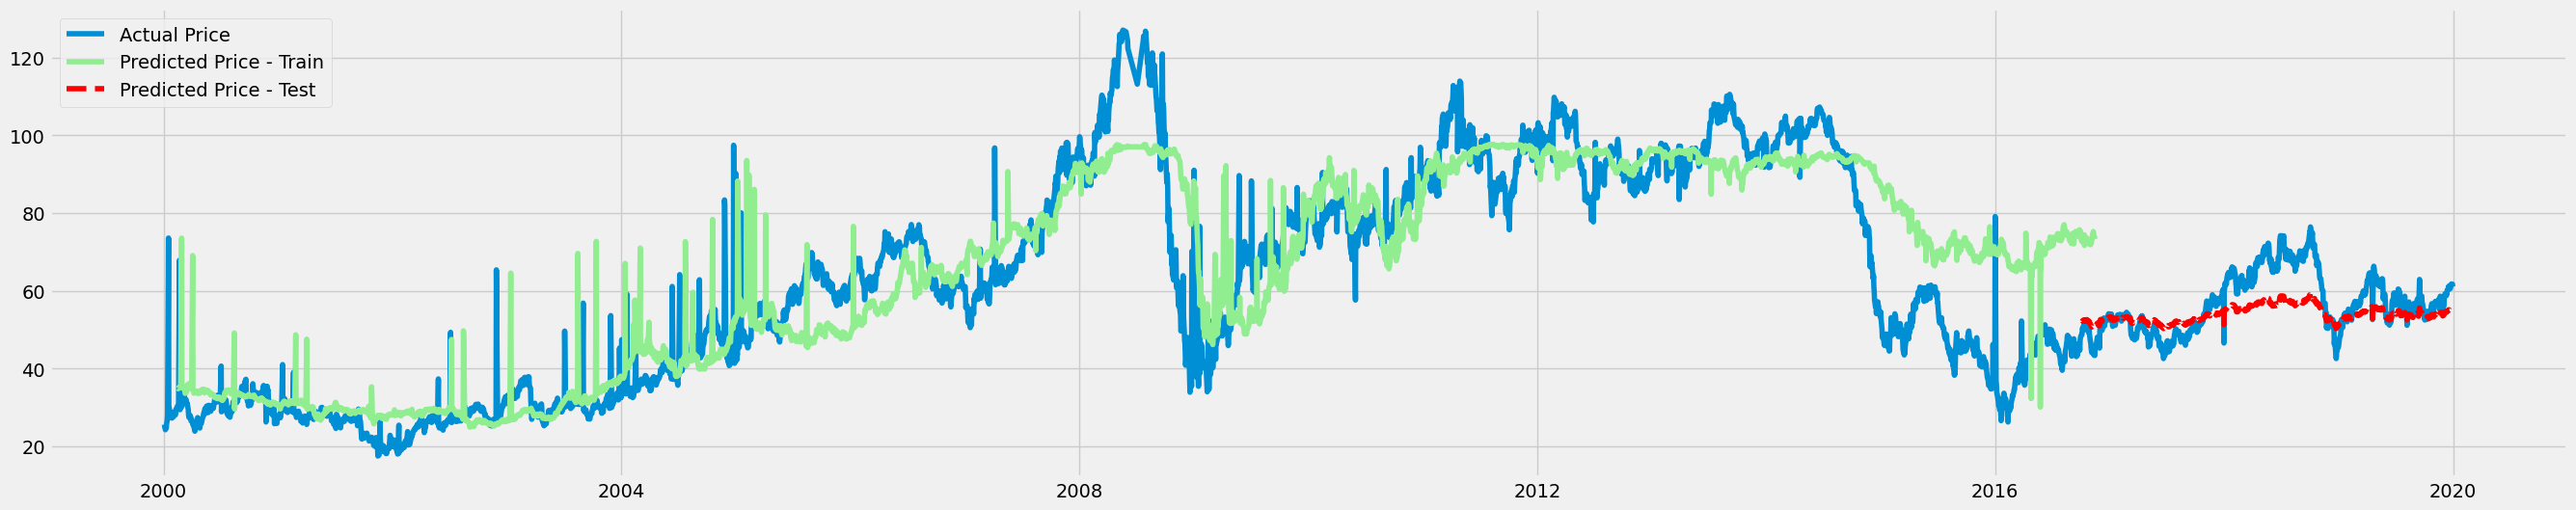

In [438]:
time_step=30
# Plot the actual prices
plt.figure(figsize=(30, 6))
ax = plt.subplot(111)
ax.plot(dataset2.index, dataset2['crudeoil_price'], label='Actual Price')

# Plot the predicted prices for the training dataset
ax.plot(dataset2.index[time_step:len(train_predict_gru) + time_step], train_predict_gru.reshape(-1), label='Predicted Price - Train', color='lightgreen')

# Plot the predicted prices for the test dataset
ax.plot(dataset2.index[-len(test_predict_gru):], test_predict_gru.reshape(-1), label='Predicted Price - Test', color='r', linestyle='dashed')

plt.legend(loc='upper left')
plt.show()

In [439]:
input_price2

array([[5091],
       [5092],
       [5093],
       [5094],
       [5095],
       [5096],
       [5097],
       [5098],
       [5099],
       [5100],
       [5101],
       [5102],
       [5103],
       [5104],
       [5105],
       [5106],
       [5107],
       [5108],
       [5109],
       [5110],
       [5111],
       [5112],
       [5113],
       [5114],
       [5115],
       [5116],
       [5117],
       [5118],
       [5119],
       [5120],
       [5121],
       [5122],
       [5123],
       [5124],
       [5125],
       [5126],
       [5127],
       [5128],
       [5129],
       [5130],
       [5131],
       [5132],
       [5133],
       [5134],
       [5135],
       [5136],
       [5137],
       [5138],
       [5139],
       [5140],
       [5141],
       [5142],
       [5143],
       [5144],
       [5145],
       [5146],
       [5147],
       [5148],
       [5149],
       [5150]])

In [440]:
import time
import datetime
from datetime import date, timedelta

# predict using last 30 days data
input_price2 = val_index[-60:].reshape((60, 1))
yhat2 = model_gru.predict(input_price2, verbose=0)

# transformback to original form
new_predict2=scaler.inverse_transform(yhat2)

# store to dataframe
prices2 = []
today_date = date.today()
day = pd.date_range(start=today_date, periods=1)

for i in new_predict2[0]:
        prices2.append(i)

new_df2 = pd.DataFrame(prices2)
new_df2.insert(0, "Date", day)
new_df2 = new_df2.rename(columns={0:"PredictPrice"})
new_df2["PredictPrice"] = new_df2["PredictPrice"]

new_df2.sort_index(inplace=True)
new_df2 = new_df2.set_index(pd.DatetimeIndex(new_df2["Date"])) # set index using date
new_df2.drop(columns="Date", inplace=True) # drop date column since already have datetimeindex
new_df2.columns = ["crudeoil_price"] # rename column

prices_df2 = dataset2[["crudeoil_price"]].copy() # copy hist dataset
new_rows2 = new_df2[["crudeoil_price"]] # take forecasted prices
prices_df2 = pd.concat([dataset2, new_df2])  # append historical + future prices

prices_df2.tail(10)


crudeoil_price
Date                      
2019-12-19       61.220000
2019-12-20       60.440000
2019-12-23       60.520000
2019-12-24       61.110000
2019-12-25       61.190000
2019-12-26       61.680000
2019-12-27       61.720000
2019-12-30       61.680000
2019-12-31       61.060000
2024-07-27       56.587292

In [441]:
ds_predict_zscore

crudeoil_price
Date                      
2000-01-04           25.55
2000-01-05           24.91
2000-01-06           24.78
2000-01-07           24.22
2000-01-10           24.67
...                    ...
2019-12-25           61.19
2019-12-26           61.68
2019-12-27           61.72
2019-12-30           61.68
2019-12-31           61.06

[5151 rows x 1 columns]

In [442]:
dataset_prophet = ds_predict_zscore
dataset_prophet

crudeoil_price
Date                      
2000-01-04           25.55
2000-01-05           24.91
2000-01-06           24.78
2000-01-07           24.22
2000-01-10           24.67
...                    ...
2019-12-25           61.19
2019-12-26           61.68
2019-12-27           61.72
2019-12-30           61.68
2019-12-31           61.06

[5151 rows x 1 columns]

In [443]:
dataset_prophet = dataset_prophet.reset_index()
dataset_prophet

Date  crudeoil_price
0    2000-01-04           25.55
1    2000-01-05           24.91
2    2000-01-06           24.78
3    2000-01-07           24.22
4    2000-01-10           24.67
...         ...             ...
5146 2019-12-25           61.19
5147 2019-12-26           61.68
5148 2019-12-27           61.72
5149 2019-12-30           61.68
5150 2019-12-31           61.06

[5151 rows x 2 columns]

In [444]:
dataset_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5151 entries, 0 to 5150
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5151 non-null   datetime64[ns]
 1   crudeoil_price  5151 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 80.6 KB


In [445]:
dataset_prophet.columns = ['ds', 'y']
dataset_prophet.head()

ds      y
0 2000-01-04  25.55
1 2000-01-05  24.91
2 2000-01-06  24.78
3 2000-01-07  24.22
4 2000-01-10  24.67

In [446]:
# Define custom scoring function
def score_func(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [447]:
# Create a TimeSeriesSplit object with n_splits=5
tscv = TimeSeriesSplit(n_splits=5)
scores = []
for train_index, val_index in tscv.split(dataset_prophet):
    X_train3 = dataset_prophet.iloc[train_index]
    y_val3 = dataset_prophet.iloc[val_index]

    model_prophet = Prophet(yearly_seasonality=True)#, weekly_seasonality=True, daily_seasonality=True)
    model_prophet.fit(X_train3)
    
    future = model_prophet.make_future_dataframe(periods=365 * 5)
    forecast = model_prophet.predict(future)

    test_predictions = forecast.iloc[-len(y_val3):][['yhat']].reset_index(drop=True)

    # Calculate the score for this split
    score = score_func(y_val3[['y']], test_predictions)
    scores.append(score)


14:27:13 - cmdstanpy - INFO - Chain [1] start processing


14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:30 - cmdstanpy - INFO - Chain [1] start processing
14:27:32 - cmdstanpy - INFO - Chain [1] done processing
14:27:40 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
14:27:57 - cmdstanpy - INFO - Chain [1] done processing


In [448]:
# Calculate the mean score
mean_score = sum(scores) / len(scores)
print('Score:' + str(mean_score))

Score:57.31512309610989


In [449]:
# Fit the model with all the data
model_prophet = Prophet(yearly_seasonality=True)
model_prophet.fit(dataset_prophet)

14:28:03 - cmdstanpy - INFO - Chain [1] start processing
14:28:11 - cmdstanpy - INFO - Chain [1] done processing


In [450]:
future = model_prophet.make_future_dataframe(periods=365 * 5)
forecast = model_prophet.predict(future)
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2000-01-04  31.161426   19.252265   38.686911    31.161426    31.161426   
1    2000-01-05  31.151195   20.474178   39.002868    31.151195    31.151195   
2    2000-01-06  31.140963   20.957174   39.461947    31.140963    31.140963   
3    2000-01-07  31.130731   20.351357   39.016242    31.130731    31.130731   
4    2000-01-10  31.100036   20.311873   38.682724    31.100036    31.100036   
...         ...        ...         ...         ...          ...          ...   
6971 2024-12-25  91.203224  -97.764060  267.408516   -93.503812   268.099783   
6972 2024-12-26  91.218097  -99.013504  268.259885   -93.537431   268.260029   
6973 2024-12-27  91.232970  -94.849583  267.422039   -93.571051   268.420275   
6974 2024-12-28  91.247843 -100.076880  265.192978   -93.604671   268.580521   
6975 2024-12-29  91.262716 -100.721807  265.598072   -93.638290   268.740767   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0          -1.834115             -1.834115             -1.834115  0.462778   
1          -1.732457             -1.732457             -1.732457  0.526939   
2          -1.486758             -1.486758             -1.486758  0.747557   
3          -1.324457             -1.324457             -1.324457  0.897299   
4          -1.409536             -1.409536             -1.409536  0.847295   
...              ...                   ...                   ...       ...   
6971       -2.559079             -2.559079             -2.559079  0.526939   
6972       -2.231930             -2.231930             -2.231930  0.747557   
6973       -1.976663             -1.976663             -1.976663  0.897299   
6974       -5.899696             -5.899696             -5.899696 -3.128332   
6975       -3.027052             -3.027052             -3.027052 -0.353537   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0         0.462778      0.462778 -2.296893     -2.296893     -2.296893   
1         0.526939      0.526939 -2.259397     -2.259397     -2.259397   
2         0.747557      0.747557 -2.234315     -2.234315     -2.234315   
3         0.897299      0.897299 -2.221757     -2.221757     -2.221757   
4         0.847295      0.847295 -2.256830     -2.256830     -2.256830   
...            ...           ...       ...           ...           ...   
6971      0.526939      0.526939 -3.086018     -3.086018     -3.086018   
6972      0.747557      0.747557 -2.979488     -2.979488     -2.979488   
6973      0.897299      0.897299 -2.873962     -2.873962     -2.873962   
6974     -3.128332     -3.128332 -2.771364     -2.771364     -2.771364   
6975     -0.353537     -0.353537 -2.673515     -2.673515     -2.673515   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
6971                   0.0                         0.0   
6972                   0.0                         0.0   
6973                   0.0                         0.0   
6974                   0.0                         0.0   
6975                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
0                            0.0  29.327311  
1                            0.0  29.418737  
2                            0.0  29.654205  
3                            0.0  29.806274  
4                            0.0  29.690500  
...                          ...        ...  
6971                         0.0  88.644145  
6972                         0.0  88.986167  
6973                         0.0  89.256307  
6974                         0.0  85.348147  
6975                   

In [451]:
forecast[forecast.ds == "2023-12-31"]

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
6611 2023-12-31  85.848903  -47.859771  213.548092   -45.113164   215.639719   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
6611       -2.913969             -2.913969             -2.913969 -0.353537   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
6611     -0.353537     -0.353537 -2.560432     -2.560432     -2.560432   

      multiplicative_terms  multiplicative_terms_lower  \
6611                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
6611                         0.0  82.934935

In [452]:
# fig = plot_plotly(model_prophet, forecast)
# fig.show()

In [453]:
# Contoh data y_true dan y_pred
y_true = dataset_prophet['y'].values[:4807]  # Ambil nilai array dari kolom 'y', sesuaikan dengan panjang y_pred
y_pred = forecast['yhat'][:4807].values  # Ambil nilai prediksi untuk periode yang sesuai dengan y_true

# Hitung RMSE
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))

# Hitung MSE
mse_prophet = mean_squared_error(y_true, y_pred)

# Hitung MAE
mae_prophet = mean_absolute_error(y_true, y_pred)

# Hitung R2 Score
r2 = r2_score(y_true, y_pred)

# Print hasil
print("RMSE:", round(rmse_prophet, 3))
print("MSE:", round(mse_prophet, 3))
print("MAE:", round(mae_prophet, 3))
print("R2 Score:", round(r2, 3))

RMSE: 7.462
MSE: 55.686
MAE: 5.56
R2 Score: 0.919


c:\Users\Rizal\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Rizal\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Rizal\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

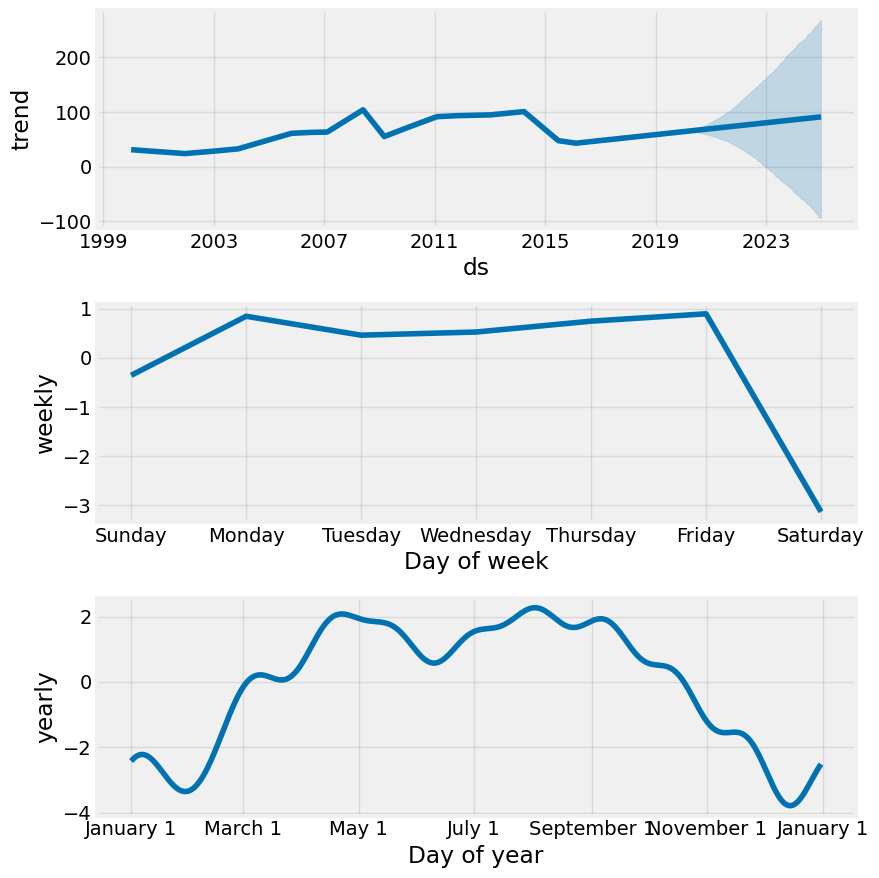

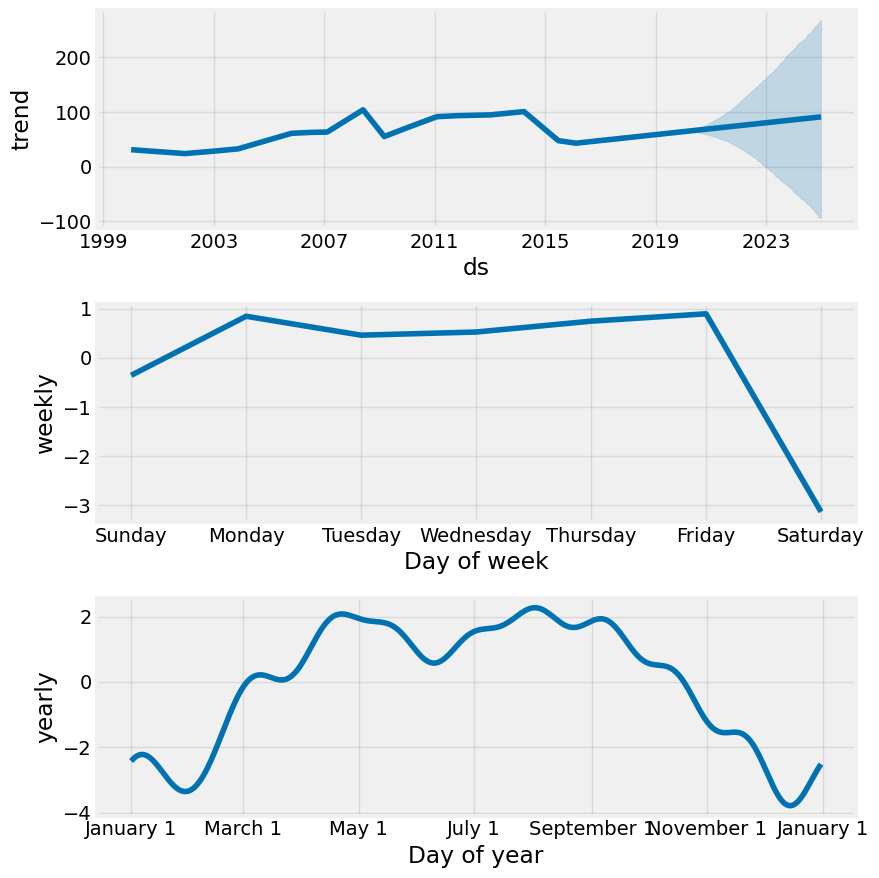

In [454]:
model_prophet.plot_components(forecast)

In [455]:
data_prophet = forecast[['ds','yhat_lower','yhat','yhat_upper']]

In [456]:
data_prophet.tail()

ds  yhat_lower       yhat  yhat_upper
6971 2024-12-25  -97.764060  88.644145  267.408516
6972 2024-12-26  -99.013504  88.986167  268.259885
6973 2024-12-27  -94.849583  89.256307  267.422039
6974 2024-12-28 -100.076880  85.348147  265.192978
6975 2024-12-29 -100.721807  88.235665  265.598072

In [457]:
data_prophet.set_index('ds', inplace=True)

In [458]:
dataset_prophet.set_index('ds', inplace=True)

In [459]:
ds_prophet = pd.concat([dataset_prophet, data_prophet], axis=1)
ds_prophet

y  yhat_lower       yhat  yhat_upper
ds                                                  
2000-01-04  25.55   19.252265  29.327311   38.686911
2000-01-05  24.91   20.474178  29.418737   39.002868
2000-01-06  24.78   20.957174  29.654205   39.461947
2000-01-07  24.22   20.351357  29.806274   39.016242
2000-01-10  24.67   20.311873  29.690500   38.682724
...           ...         ...        ...         ...
2024-12-25    NaN  -97.764060  88.644145  267.408516
2024-12-26    NaN  -99.013504  88.986167  268.259885
2024-12-27    NaN  -94.849583  89.256307  267.422039
2024-12-28    NaN -100.076880  85.348147  265.192978
2024-12-29    NaN -100.721807  88.235665  265.598072

[6976 rows x 4 columns]

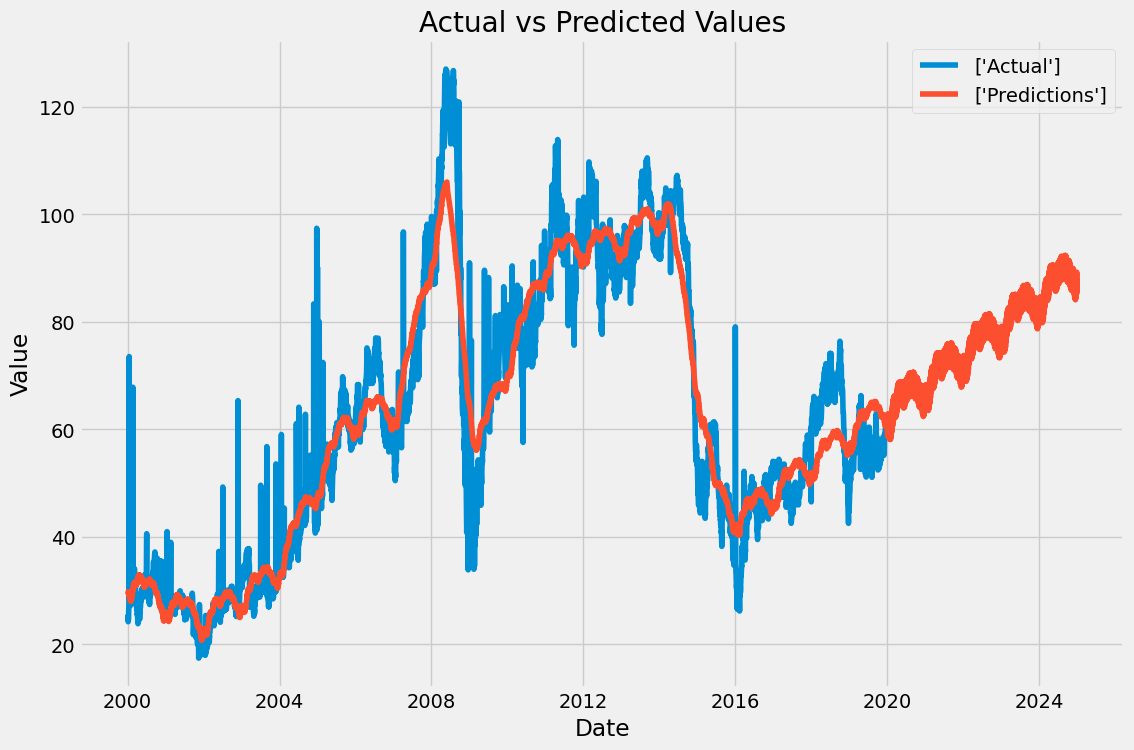

In [460]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(ds_prophet.index, ds_prophet['y'], label=["Actual"])
plt.plot(ds_prophet.index, ds_prophet['yhat'], label=["Predictions"])

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [461]:
import pickle
# Save the model to a pickle file
with open(r'model\crude-oil-prophet-fix.pkl', 'wb') as f:
    pickle.dump(model_prophet, f)

In [462]:
rmse_errors = [test_rmse_lstm, test_rmse_gru, rmse_prophet]
mse_errors = [test_mse_lstm, test_mse_gru, mse_prophet]
errors = pd.DataFrame({"Models" : ["LSTM", "GRU", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
errors

Models  RMSE Errors  MSE Errors
0     LSTM     0.059032    0.059032
1      GRU     0.057941    0.057941
2  Prophet     7.462304   55.685975

ValueError: x and y must have same first dimension, but have shapes (5151,) and (6976,)

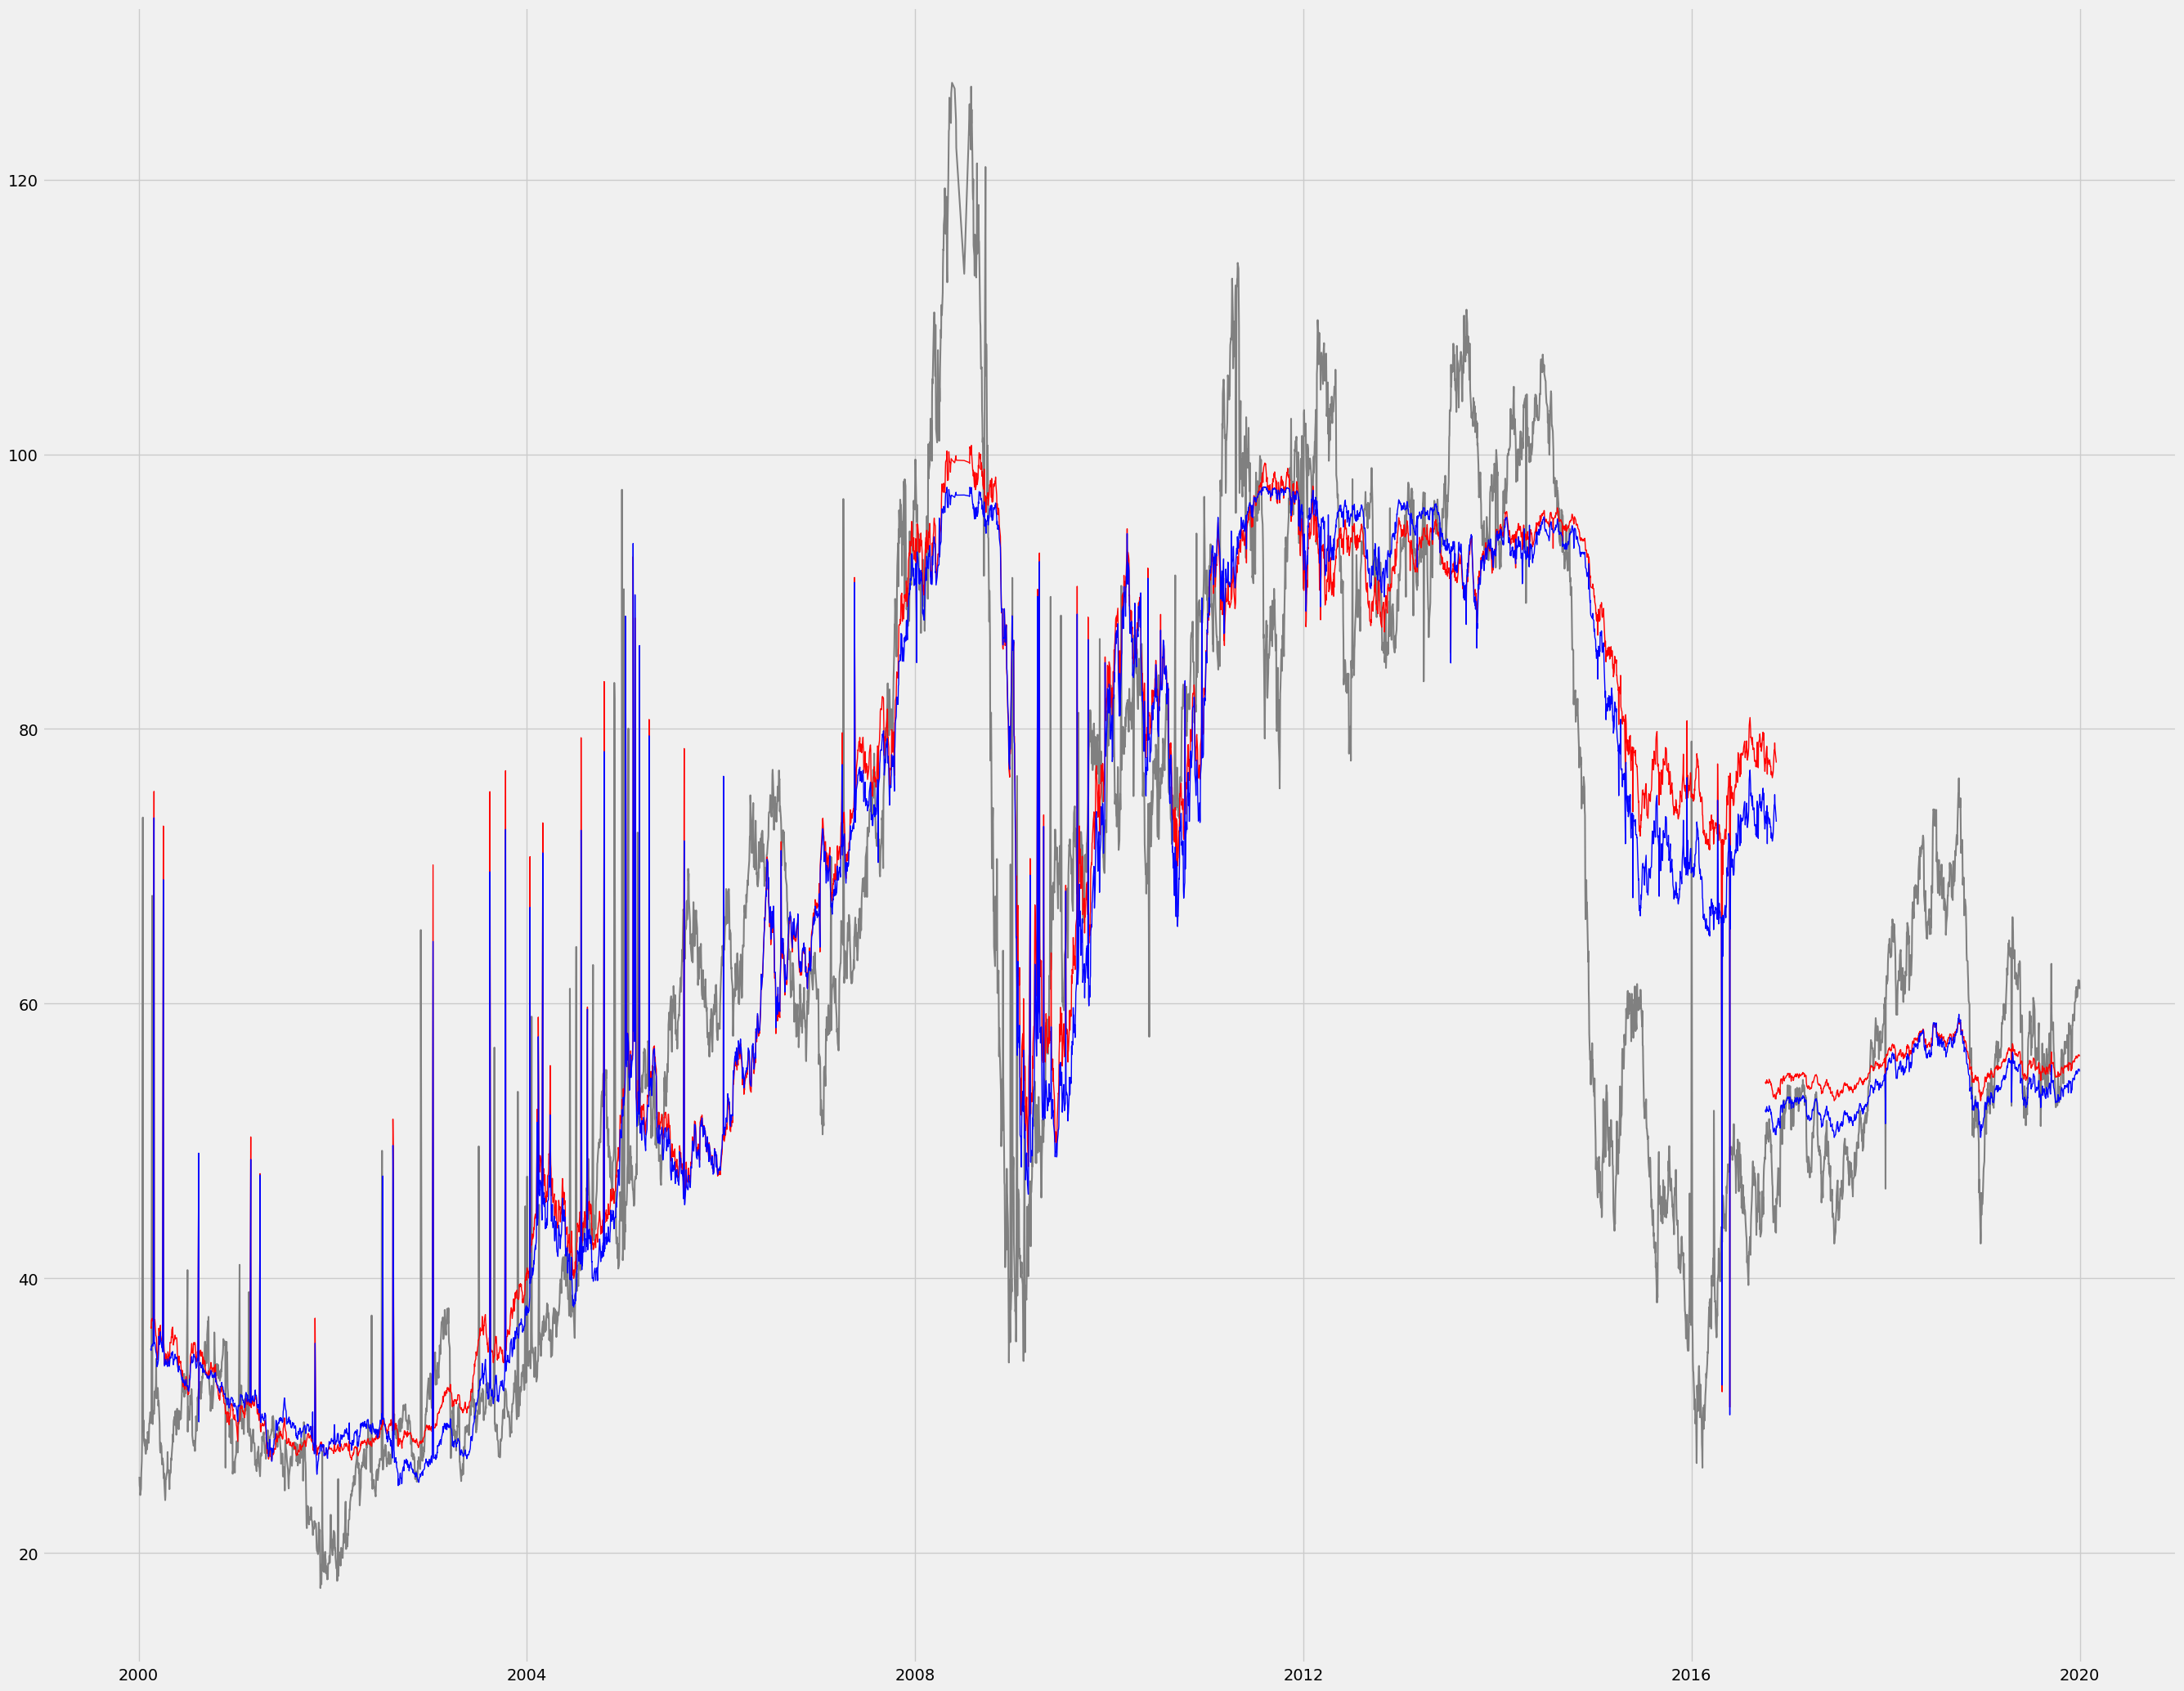

In [463]:
import matplotlib.pyplot as plt
import pandas as pd

# Asumsi df1, train_predict, test_predict, train_predict_gru, test_predict_gru, df_cv_prophet, dan forecast sudah didefinisikan sebelumnya

# Mengatur ukuran figure
plt.figure(figsize=(30,25))

# Plot actual prices
plt.plot(ds_predict_zscore.index, ds_predict_zscore['crudeoil_price'], label='Actual Price', color='grey', linestyle='-', linewidth=1.5)

# Plot prediksi LSTM
plt.plot(ds_predict_zscore.index[time_step:len(train_predict) + time_step], train_predict.reshape(-1), label='Predicted Price - Train (LSTM)', color='red', linestyle='-', linewidth=1.0)
plt.plot(ds_predict_zscore.index[-len(test_predict):], test_predict.reshape(-1), label='Predicted Price - Test (LSTM)', color='red', linewidth=1.0)

# Plot prediksi GRU
plt.plot(ds_predict_zscore.index[time_step:len(train_predict_gru) + time_step], train_predict_gru.reshape(-1), label='Predicted Price - Train (GRU)', color='blue', linestyle='-', linewidth=1.0)
plt.plot(ds_predict_zscore.index[-len(test_predict_gru):], test_predict_gru.reshape(-1), label='Predicted Price - Test (GRU)', color='blue', linewidth=1.0)

# Plot prediksi Prophet
#pred = forecast[forecast['ds'].isin(df_cv_prophet['ds'])]
plt.plot(ds_predict_zscore.index, ds_prophet['yhat'], label="Predicted (Prophet)", color='orange', linestyle='-', linewidth=1.0)

# Menambahkan judul dan legendas
plt.title('Comparison of LSTM, GRU, and Prophet Model Predictions')
plt.xlabel('Date')
plt.ylabel('Crude Oil Price')
plt.legend(loc='upper left')

# Menampilkan plot
plt.tight_layout()
plt.show()


In [ ]:
TESTING

In [ ]:
def forecast_future_price(dataframe):
    today_date = date.today()
    days = pd.date_range(start=today_date, periods=3)
    yesterday = today_date - timedelta("%Y-%m-%d")
    today_date = today_date.strftime("%Y-%m%-%d")

    hist_df = dataframe
    